In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### This notebook is best accessed through Google Colab here: https://colab.research.google.com/drive/1IYk6vCo8dk6UgbO2ETEt3LeRPeR3G2Sd?usp=sharing

### The folder containing all files needed for this project (including trained models that can be directly loaded) can be downloaded here: https://drive.google.com/drive/folders/1lZVst4fI5_FrjIJPeTh8bxKzltZzJRYX?usp=sharing


# Personalized Autocomplete
### Next word prediction part 2 - Using sequence to sequence model with attention

## Introduction

The following project is a continuation of the previous project, where we worked on developing an architecture that relied on converting the input text sequences using GloVe embeddings and then developing an architecture that relied on LSTM cells to make predictions for the next sequences.

In this project, we will be using a different architecture that relies on sequence to sequence model with attention. The vanilla architecture was proposed in the paper [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) by Bahdanau et al. In this project, we will be taking the proposed architecture and improving upon it to make it suitable for the task of next word prediction.

Moreover, in addition to accuracy we used in the last project, we will be including several more sophisticated metrics: *top-k accuracy*, *perplexity*, *cosine similarity*.

**Important note:** his notebook *directly* reuses some of the ***functions*** **and** ***explanations*** from the previous notebook; e.g. entirety of preprocessing and data generation functions and their explanations are the same.

### Dataset

In the previous project, the original plan of the project was to track all of my keylogs using a keylogger (the code for which is provided below) and using that train a model that would serve as a personalized autocompleter. However, as demonstrated in the previous project, the keylogs were not nearly enough to provide great results. A simple proof of this is that the number of unique tokens (words) was less than 3,500. This is because at the time I had only used the keylogger for a couple of days. Compared to around 47,000 average number of unique tokens that I have used in the last 2-3 months, as provided by Grammarly, this is a very small number that is not enough to provide representative or great results even with an excellent model.

To battle this, I had merged the keylogs with several public domain books that I believe use language somewhat similar to mine and that I find have had an important impact on my linguistic style such as Harry Potter book series, some Dostoyevsky works, etc. which were available on project Gutenberg. This increased the number of unique tokens to beyond 100,000 and provided much better results.

The number of words needed to provide great results is unfortunately more of an art than a science. It is heavily dependent on the architecture choices,  complexity of the language, the specific domain or genre of the text, and the quality of the data. In general, the more data you have, the better the results will be.

For ChatGPT it turned out that "just" 175 billion parameters, a slightly more sophisticated transformers architecture and probably between 1 trillion and 100 trillion words proved sufficient to be able to model the complex distribution that human speech has in about 95 languages (as per Mr. Wolfram's [What Is ChatGPT Doing … and Why Does It Work?](https://writings.stephenwolfram.com/2023/02/what-is-chatgpt-doing-and-why-does-it-work/))

In the case of the model that we will be using in this project, the AI lore suggests that between tens to hundreds of thousands of sentences should be sufficient to provide great results, which is far greater than the number of words that I have logged in the last month.

Rather than just adding books data and by doing that dilluting the impact of my own personal data, I have put an emphasis on using my own data. Besides having more of my own personal data, I have scraped all of the text I have written in previous papers, reports, projects, etc. As this still is not comparable to the amount of text in books, I have decided to add a data augmentation step to my pipeline.  

I have also ran the model on the exact same dataset as in the previous project for comparison purposes.

### The (mathematical) goal of the project

*the following text is similar to the one in the previous project*

Our goal is remains the same. Given an input of sequence of words, predict what the most likely next word in the sequence is.

As before, although our end goal will at times be to generate entire paragraphs form the input text, we will only be predicting a single word *at a time*. Although predicting more words in a batch is certainly possible, single word prediction is useful since it is more close to the autocomplete feature and accuracy is higher given a smaller dataset.

Since we want to generate sequences longer than just 1 word, we will predict the next word $w_{i+1}$ and then append the predicted to the previous input sequence. Using that newly updated input sequence we will be able to generate the next word in the sequence. This process can be repeated to generate as long of a sequence as we want.

#### Example

To demonstrate, let's say that the number of words we predict on is 3 and our initial input sequence is $\{"today", "was", "a"\}$ and our goal is to predict the next 2 words.

Let us assume that our model predicted the next word in the sequence to be "good" giving us the total sequence to be $\{"today", "was", "a", "good"\}$. We can now move the sliding window of size 3 to use the last 3 words of this (we added "good" to the end of the input sequence and dropped "today"). We now use this new input sequence $\{"was", "a", "good"\}$ to predict the next word which would ideally be $\{"day"\}$ fulfilling Ice Cube's lyrics. However, it is entirely possible that some other word could be predicted such as $\{"boy"\}$. This is entirely dependent on the distribution learned from the training data. "was a good boy" makes sense, however, "today was a good boy" does not. To mitigate this, we will use much larger sequences of words (around 50/100/150/200) to predict the next word in the sequence which will hopefully provide more context and make the model more robust.

Essentially, the goal of the model is to learn and mimic from the training data as best as possible the probability distribution of the next word, given the previous words in the sequence, which is done through Bayes' rule:

We can represent the abovementioned problem as a conditional probability problem:

$P(w_{t+1} | w_1, w_2, ..., w_{t})$

where $w_{t+1}$ is the target word we want to predict, and $w_1$, $w_2$, ..., $w_{t}$ are the previous words in the sequence. $w_{t+1}$ can be any of the words in the vocabulary $V$. Vocabulary is the set of all possible words that can be predicted.

Our goal is to find the word $w_{t+1}$ that maximizes the probability of the next word given the previous words. To do this, we find need to find the probability distribution for each word in the vocabulary.

For example, if we have the vocabulary $V = \{a, b, c, d\}$ and the input sequence is $w_1 = a, w_2 = b, w_3 = c$, and we want to predict the next word $w_4$, we want to calculate the probability of each word in the vocabulary being the next word in the sequence.

Thus, we want to find:

$P(w_4 = a | w_1 = a, w_2 = b, w_3 = c)$ <br>
$P(w_4 = b | w_1 = a, w_2 = b, w_3 = c)$ <br>
$P(w_4 = c | w_1 = a, w_2 = b, w_3 = c)$

After obtaining the probability of each word in the vocabulary being the next word in the sequence, we can simply pick the word with the highest probability.


To be more mathematically rigorous, we can express this probability through the chain rule of probability by multiplying the probabilities of each word in the sequence:
* Probability of the first word in the sequence being $w_1$ = $P(w_1)$
* Probability of the second word in the sequence being $w_2$ given that the first word in the sequence is $w_1$ = $P(w_2 | w_1)$
* Probability of the third word in the sequence being $w_3$ given that the first two words in the sequence are $w_1$ and $w_2$ = $P(w_3 | w_1, w_2)$
* And so on...

In general, we have the probability that the word $w_i$ is word $V_{kth}$ which represents the $kth$ word in vocabulary, given that first i-1 words in the sequence are $w_1, w_2, ..., w_{i-1}$ as

$ P(w(1), w(2), ..., w(i)=V_{kth}) \\=P(w(1)) \times P(w(2) | w(1)) \times P(w(3) | w(1), w(2)) \times ... \times P(w(i) = V_{kth} | w(1), w(2), ..., w(i-1)) \\ =\Pi_{t=1}^{T} P(w_{t} = V_{kth}| w_{t},...,w_{1})$

Now, although uninferrable for us humans through simple rules, our training data (and every text for that matter) has some probability distribution for each word in the vocabulary given some input sequence. Learning and proximatomg this distribution as best as possible is exactly what our model does.

Extending this idea further, a bigger and more diverse representative dataset of my own speech, would lead to a far more representative distribution of my own "true" speech (if conceptually such a thing exists).

Referring back to ChatGPT, since their goal was to somewhat mimic all human knowledge, they needed to use a dataset that had all available human knowledge (books, webpages, video transcriptions, etc.)








## Pipeline


Below is the general overview of the project pipeline (slight additions to the pipeline from the previous project). Individual choices and decisions are explained in the corresponding sections.

1. Get data
    1. Keylogs
        1. Use keylogger to record keystrokes
        2. Merge keylogs into one file
    2. Extract all of my own text documents:
        1. Research papers
        2. Notes
        3. Emails
        4. Projects
        5. Text messages
    3. Books and articles from Project Gutenberg
        1. Download books and articles
        2. Merge books and articles into one file
2. Data augmentation of my own personal data
    1. Rewrite sentences with synonyms instead of particular words
    2. Rewrite sentences with some word exchanged with words that are closest to them in the embedding space.
    3. Paraphrase sentences in many different ways using a pretrained LLM (like ChatGPT)
    4. Duplicate the text.
3. Merge all text into a single file
4. Data processing
    1. Lowercase
    2. Single whitespace
    3. Remove punctuation
    4. Remove numbers
    5. Widen contractions
    6. (keylogs) Fix typos
    7. (keylogs) Remove emojis
    8. [optional] (keylogs) Remove non-English
    9. Remove stopwords
    9. Split into tokens
    10. Lemmatize or Stem (Lemmatize preferred)
5. Tokenization
6. Create features and target sequences (N-grams)
7. Split into train, validation, and test sets
    1. Train: 80%
    2. Validation: 10%
    3. Test: 10%
8. Vectorization - Creating an embedding matrix from GloVe
9. Create and train the model: Seq2Seq with Attention and LSTM
    1. Model architecture
    2. Hyperparameters
    3. Training
    4. Save model
10. Evaluation
    1. Accuracy
    2. Top k accuracy
    3. Perplexity
    4. Cosine similarity



Necessary installs:
1. pip install TextBlob
2. pip install tensorflow (or tensorflow-gpu) and keras
3. pip install nltk
4. pip install git+https://github.com/MCFreddie777/language-check.git
5. pip install contractions
6. pip install pycontractions
7. pip install numpy
8. pip install scikit-learn
9. pip install pandas
10. pip install matplotlib
11. pip install regex
12. pip install pynput
13. pip install win32gui
14. pip install fuzzywuzzy

In [2]:
!pip install contractions # if running in colab this is necessary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.7 MB/s eta 0:00:00


## Keylogger


Below I have written the code for the keylogger. This is only to demonstrate the code and not to be run (you can click f12 to terminate the script if running). This script can be found withing the './keylogger/' folder. It was run on startup (the code to create it to a bat file and to run it on startup can be found in the './keylogger/' folder as well).

The final optimized version of the keylogger found below fully record everything that the user inputs into the keyboard and mimics functions such as ctrl + backspace as well (which I frequently use). One drawback is that it always assume that the cursor pointer is at the end of the text, however, given that this does not happen most of the time which it statistically won't, given enough data, it will not be a problem and can be dealt with in the data processing stage. The keylogger keeps a dictionary for every active window the user writes and then applies the text changes done in that window. When the script terminates, all the values of the dictionary are added sequentially thus preventing the previous problem of words being from mixed contexts. Finally, for every different run the keylogger generates a different txt file.

For iOS users, use use pyautogui.getActiveWindowTitle() to get the active window instead of win32gui.

In [3]:
def run_keylogger():
    import logging
    from pynput import keyboard
    import os
    import pickle as pkl
    import re
    from win32gui import GetWindowText, GetForegroundWindow

    # Log the keystrokes to the console with the current date and time
    logging.basicConfig(level=logging.INFO, format='%(asctime)s: %(message)s')

    # List of non-alphanumeric characters that are allowed to be typed
    SPECIAL_CHARS = ('.', ';', ',', '/', '\\', '"', "'", '(', ')',
                     '[', ']', '{', '}', '<', '>', '!', '?', ':', '-', '_', '=', '+', '*', '&', '^', '%', '$', '#', '@', '~', '`')
    # List of keys to ignore
    NONALLOWED_KEYS = [keyboard.Key.esc, keyboard.Key.caps_lock, keyboard.Key.ctrl_r,
                       keyboard.Key.alt, keyboard.Key.alt_l, keyboard.Key.alt_r, keyboard.Key.cmd, keyboard.Key.cmd_l,
                       keyboard.Key.cmd_r, keyboard.Key.up, keyboard.Key.down, keyboard.Key.left, keyboard.Key.right,
                       keyboard.Key.f1, keyboard.Key.f2, keyboard.Key.f3, keyboard.Key.f4, keyboard.Key.f5, keyboard.Key.f6,
                       keyboard.Key.f7, keyboard.Key.f8, keyboard.Key.f9, keyboard.Key.f10, keyboard.Key.f11, keyboard.Key.delete]

    # deletes the existing pickle file - uncomment only if you want to start from 1 again
    #open("lastfile.pkl", "w").close()

    try:  # try to load the pickle file
        with open('lastfile.pkl', 'rb') as fp:
            lastfile = pkl.load(fp)  # load the pickle file
            logging.info(
                f"Pickle file found. Last log file number: {lastfile}. Initializing log file {lastfile+1}.")
    except (FileNotFoundError, EOFError):  # error catch if the file is not found or empty
        logging.info("Pickle file not found. Initializing log files from 1.")
        lastfile = 0

    # GLOBAL VARIABLES
    # Create a dictionary to store the words written in the currently active window
    window_words = {}  # key: window title, value: list of words
    ctrl_l_pressed = False  # check if ctrl_l is pressed

    def mimic_ctrl_backspace(input_string):
        """
        Mimics the ctrl + backspace functionality in the terminal.
        Takes the input string, assumes the cursor is at the end of the string and mimics what happens when you press ctrl + backspace.

        Parameters
        ----------
        input_string : str
            The string to mimic the ctrl + backspace functionality on.

        Returns
        -------
        str
            The modified string after the ctrl + backspace functionality is applied.
        """
        if len(input_string) <= 1:  # if the input string is empty or has only one character
            return ''
        else:  # len(input_string) > 1
            # if the last two characters are spaces
            if input_string[-1] == ' ' and input_string[-2] == ' ':
                # remove all the whitespace at the end of the input_string
                input_string = re.sub(r"\s+$", "", input_string)
                return input_string
            # if the last character is a space and the penultimate character is alphanumeric
            elif input_string[-1] == ' ' and input_string[-2].isalnum():
                # first remove all the whitespace at the end of the input_string
                input_string = input_string.rstrip()
                while len(input_string) > 0 and input_string[-1] not in SPECIAL_CHARS and input_string[-1] != ' ':
                    # keep removing last character until a space or a special character is found or the string is empty
                    input_string = input_string[:-1]
                return input_string
            else:
                if input_string[-1].isalnum():  # if the last character is alphanumeric
                    while len(input_string) > 0 and input_string[-1] not in SPECIAL_CHARS and input_string[-1] != ' ':
                        # keep removing last character until a space or a special character is found or the string is empty
                        input_string = input_string[:-1]
                # if the last character is not alphanumeric (i.e. a special character)
                else:
                    while len(input_string) > 0 and not input_string[-1].isalnum():
                        # keep removing last character until an alphanumeric character is found or the string is empty
                        input_string = input_string[:-1]
                return input_string

    def save_keystrokes():
        """ Saves the keystrokes to a file.
        The file is saved in the logs folder and is named Log <lastfile+1>.txt

        Returns
        -------
        None
        """

        global lastfile
        lastfile += 1  # increment the lastfile number

        try:
            # create the filename
            file_name = f"Log {lastfile}.txt"
            # get the current path
            path = os.path.dirname(os.path.realpath(__file__))
            # open the file in write mode (creates or overwrites the existing file)
            with open(f'{path}/logs/{file_name}', "w") as file:
                for text in window_words.values():  # iterate through the words written in each active window
                    # append the words sequentially so there are mixed sentences from different windows
                    file.write(text)
                    file.write(" ")
                logging.info("Saved keystrokes to file: %s", file_name)

        except Exception as e:
            logging.error("Could not save keystrokes to file: %s", str(e))

    def on_press(key):
        """Appends the pressed key to the keystroke string for the currently active window. Updates the dictionary.

        Parameters
        ----------
        key : keyboard.Key
            The key that was pressed.

        Returns
        -------
        None
        """

        global ctrl_l_pressed

        try:
            # get the title of the currently active window
            # Works only on Windows. For iOS, use pyautogui.getActiveWindowTitle()
            active_window = GetWindowText(GetForegroundWindow())
            if active_window not in window_words:  # if the active window has not been used before, initialize it
                window_words[active_window] = ""

            # get the keystroke string for the currently active window
            keystroke_log = window_words[active_window]

            if key in NONALLOWED_KEYS:  # if the pressed key is not allowed
                pass
            elif key == keyboard.Key.f12:  # if the pressed key is f12, stop the keylogger and save the keystrokes
                listener.stop()
                save_keystrokes()
                logging.info("Stopped the keylogger.")
                pass
            # if the pressed key is space or enter, add a space to the keystroke_log
            elif key == keyboard.Key.space or key == keyboard.Key.enter:
                keystroke_log += " "
            # checking if ctrl_l and backspace are pressed at the same time
            elif key == keyboard.Key.ctrl_l:  # if the pressed key is ctrl_l, set ctrl_l_pressed to True
                ctrl_l_pressed = True
            elif key == keyboard.Key.backspace:  # if the pressed key is backspace
                # if ctrl_l is pressed and the keystroke_log is not empty
                if ctrl_l_pressed and len(keystroke_log) > 0:
                    # mimic the ctrl + backspace functionality
                    keystroke_log = mimic_ctrl_backspace(keystroke_log)
                else:  # if ctrl_l is not pressed or the keystroke_log is empty
                    # remove the last character from the keystroke_log
                    keystroke_log = keystroke_log[:-1]
            # if the pressed key is alphanumeric or a special character
            elif key.char.isalnum() or key.char in SPECIAL_CHARS:
                # append the pressed key to the keystroke_log
                keystroke_log += str(key).strip("'")

            # log the keystroke_log for the currently active window
            logging.info(f"{active_window}: {keystroke_log}")
            # update the keystroke_log for the currently active window
            window_words[active_window] = keystroke_log

        except:
            logging.error(
                f"Error while appending keystroke {key}. Unallowed character.")

    def on_release(key):
        """Checks if the released key is ctrl_l and sets ctrl_l_pressed to False.

        Parameters
        ----------
        key : keyboard.Key
            The key that was released.

        Returns
        -------
        None
        """

        global ctrl_l_pressed

        if key == keyboard.Key.ctrl_l:  # if the released key is ctrl_l, set ctrl_l_pressed to False
            ctrl_l_pressed = False

    try:
        # Start the keyboard listener and the timer to save the keystrokes
        with keyboard.Listener(on_press=on_press, on_release=on_release) as listener:
            listener.join()
    finally:  # save the lastfile number to a file
        with open('lastfile.pkl', 'wb') as fp:
            pkl.dump(lastfile, fp)
            print("Saved new last file number: ", lastfile)
            # wait for the user to press enter before closing the terminal
            input("\nPress Enter to close the terminal...")


### Reading the data

#### Merging text files / keylogger logs

Given that the keylogger has been running for a few days or that there are several books, the txt files have to be merged into a single txt file.

In [4]:
def merge_txt_files(input_dir=".\keylogger\logs", output_dir="database/merged", name="master.txt"):
    """Merges all .txt files in the input directory into a single .txt file in the output directory.

    Parameters
    ----------
    input_dir : str
        The path to the directory containing the .txt files to merge. Defaults to ".\keylogger\logs".
    output_dir : str
        The path to the directory where the merged 'master.txt' file will be saved. Defaults to "database".

    Returns
    -------
    None
    """

    import os

    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        print(
            "Creating a folder '{output_dir}' to store the merged text file...")
        os.makedirs(output_dir)

    # Merge the contents of all .txt files in the input directory into a single string
    merged_text = ""
    for filename in os.listdir(input_dir):
        if filename.endswith(".txt"):
            with open(os.path.join(input_dir, filename), "r") as f:
                merged_text += f.read()
    print(
        f"Merged all .txt files from the {input_dir} folder into a single variable.")

    # Write the merged text to a new file in the output directory
    output_filename = os.path.join(output_dir, name)
    with open(output_filename, "w") as f:
        f.write(merged_text)
    print(f"Saved the merged text to ./{output_filename}")


In [5]:
#merge_txt_files(input_dir='/content/drive/MyDrive/PredictNextWords/database/hp_unprocessed', output_dir='/content/drive/MyDrive/PredictNextWords/database/merged')

#### Reading the master text file

Below is the function used to read a text file and return a string containing the entire dataset which we use in our preprocessing.

In [6]:
def read_txt_file(file_name, folder_path="/content/drive/MyDrive/PredictNextWords/database/processed/", encoding="utf-8"):
    """Reads a text file.

    Parameters
    ----------
    file_name : str
        The name of the text file.
    folder_path : str (optional)
        The path to the folder containing the text file. Defaults to "./database/processed/".
    encoding : str (optional)
        The encoding of the text file. Defaults to "utf-8".

    Returns
    -------
    text : str
        The text read from the file.
    """

    import os  # Import the os module to work with file paths

    with open(os.path.join(folder_path, file_name), 'r', encoding=encoding) as f:
        text = f.read()

    print(
        f"\nRead {file_name}. It contains {len(text)} characters and {len(text.split())} words.")
    return text


## Data Augmentation


Primarily, we will be using two libraries for preprocessing and data augmentation: regex and nltk.

Regex is used for simpler text cleaning such as finding and removing punctuation, numbers, etc., whereas NLTK is a very standard library used for more complex tasks such as tokenization, lemmatization, stemming, which can be easily done with its built-in functions.

In [7]:
import re  # regular expressions
import nltk  # natural language toolkit
nltk.download('popular')  # uncomment to download the nltk data


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

As explained above, I have decided to use data augmentation to increase the size of my dataset so it does not get dilluted when combined with the text from other sources (such as books.)

There are several methods of data augmentation that can be used and that I have used.
1. **Just recopying the same text (duplicating it) multiple times.** <br>
    This is the simplest method and can be used to increase the size of the dataset by a factor of 2, 3, 4, etc. However, this method does not provide any new information (the size of the vocabulary remains the same) and thus does not help the model learn as much variety as other methods below. Interestingly, although not necessarily proven it appears that for GPT models (perhaps also for vanilla transformer), this helps the model solidify what it has learned which is analogous to how we humans tend to remember things better when we repeat them multiple times ([What Is ChatGPT Doing … and Why Does It Work?](https://writings.stephenwolfram.com/2023/02/what-is-chatgpt-doing-and-why-does-it-work/)). Testing whether this is also true for seq2seq models is left for future work.

    Giving it the benefit of the doubt, I have used this only once by duplicating (once) the text after all the other methods have been applied.
1. **Rewriting sentences with a couple of words being replaced with synonyms from a thesaurus.** <br>
    For example: If we have a sentence: "He was really happy with his new vehicle.", we can replace the word "happy" with a synonym such as "ecstatic" and "vehicle" with "car" to get ""He was really happy with his new vehicle."
2. **Rewriting sentences with a couple of words being replaced with most similar words.** <br>We can accomplish this using pretrained embeddings such as GloVe by randomly pick one or two words and for each of them find the closest words in the embedding space and replace the word with them thus getting new sentences with similar meaning but different words. The implementation of the following is seen in the cell below.
3. **Paraphrasing sentences in many different ways using a pretraiend LLM (like ChatGPT).**<br>This was the primary method that I have used as it was really fast and provided the best results (by my subjective metric)

In [8]:
# SECOND METHOD - USING GLOVE EMBEDDINGS

import os
import numpy as np
from scipy.spatial.distance import cdist
from nltk.tokenize import word_tokenize


def replace_words_with_closest_glove_words(text, num_sentences=3, root_dir = "", glove_dir='glove/glove.6B', embedding_dim=50):
    """
    Takes in an input sentences and replaces 1 or 2 words in a text with their closest words in GloVe embeddings.

    Parameters
    ----------
    text : str
        The input text. Example: "He was really happy with his new vehicle."
    num_sentences : int
        The number of sentences to generate. Defaults to 3.

    Returns
    -------
    sentences : list
        Modified sentences.
        Example: ["He was really happy with his new vehicle.",
                  "He was really happy with his new car.",
                  "He was really happy with his new car."]
    """

    # Load GloVe embeddings
    glove_path = f"{root_dir}/{glove_dir}/glove.6B.{embedding_dim}d.txt"
    word_vectors = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_vectors[word] = vector

    # Tokenize input text
    tokens = word_tokenize(text)

    # Generate sentences with replaced words
    sentences = []
    for i in range(num_sentences):
        # Choose one or two words to replace
        num_words_to_replace = np.random.choice([1, 2])
        words_to_replace = np.random.choice(
            tokens, size=num_words_to_replace, replace=False)

        # Find closest words in GloVe embeddings
        closest_words = []
        for word in words_to_replace:
            if word in word_vectors:
                word_vector = word_vectors[word]
                distances = cdist(word_vector.reshape(1, -1),
                                  list(word_vectors.values()))
                closest_word_idx = np.argsort(distances)[0][1]
                closest_word = list(word_vectors.keys())[closest_word_idx]
                closest_words.append(closest_word)

        # Replace words in tokenized text
        new_tokens = []
        j = 0
        for k, token in enumerate(tokens):
            if token in words_to_replace:
                if j < len(closest_words):
                    new_tokens.extend(word_tokenize(closest_words[j]))
                    j += 1
                else:
                    new_tokens.append(token)
            else:
                new_tokens.append(token)

        # Generate sentence with replaced words
        new_sentence = ' '.join(new_tokens)
        sentences.append(new_sentence)

    return sentences


In [9]:
test_string = "He was really happy with his new vehicle."
print("Original text: ", test_string)
print(replace_words_with_closest_glove_words(test_string, root_dir = "/content/drive/MyDrive/PredictNextWords"))


Original text:  He was really happy with his new vehicle.
['He was really happy and he new vehicle .', 'He was really happy with he for vehicle .', 'He was really happy with he new vehicle .']


## Preprocessing

***This section is (almost) the same as in the previous project***



Preprocessing is the fundamental process of preparing the data for the model. It is a very important step as it can have a significant impact on the model's performance (can reduce complexity and number of features, increase performance by finding only the key features, etc.)


#### Converting to lowercase and stripping multiple whitespaces.

Converting all text to lowercase makes the vocabulary size smaller and prevents the model from learning different embeddings for the same word in different cases. For example, without lowercasing, the model would learn different embeddings for "Apple" and "apple," even though they refer to the same thing. If we want to do capitalization, it is better to do train the model with all lowercase so the model produces better results and then apply capitalization in the post-processing stage by applying some model that capitalizes.

The texts used contain a lot of whitespaces and although they will not necessarily increase the vocabulary size (a tokenizer will easily get rid of them), looking at the text, they are not necessary and take away from readability.

In [10]:
def lowercase_and_strip_whitespaces(text):
    """Converts a given text to lowercase and strips multiple whitespaces to a single whitespace.

    Parameters
    ----------
    text : str
        The text to convert.

    Returns
    -------
    str
        The converted text with multiple whitespaces stripped to a single whitespace and converted to lowercase.
    """
    # strip multiple whitespaces
    text = ' '.join(text.split())

    # convert to lower case
    text = text.lower()

    return text


#### Remove punctuation

Analogous to above, punctuation marks and numbers typically do not carry much meaning in natural language and can be safely removed without significant loss of information. Removing punctuation and numbers can also help to reduce the noise in the data, since these characters can appear in many different contexts and make it more difficult for models to learn the correct relationships between words.

In the case of next word prediction, removing punctuation and numbers can also help to ensure that the model is able to focus on the words themselves rather than being distracted by other characters in the input. This can help to improve the accuracy and effectiveness of the model in predicting the most likely next word given a sequence of words.

In [11]:
def remove_punctuation_and_numbers(text):
    """Removes punctuation and numbers from a given text.

    Parameters
    ----------
    text : str
        The text to remove punctuation and numbers from.

    Returns
    -------
    str
        The text with punctuation and numbers removed.
    """

    text = ''.join([char for char in text if char.isalpha() or char == ' '])
    return text


#### Widen contractions

Another thing we can do is widen the contractions we have in the text. This is useful because it helps to standardize the text and reduce the dimensionality of the data. E.g. we want "I'm" and "I am" to be deemed the same by the model and we want to reduce the number of unique words that the model needs to learn in order to make accurate predictions.

Widening contractions involves expanding commonly used contractions (e.g., "can't" to "cannot", "won't", etc.) into their full forms. By expanding contractions, we are converting a single word (the contraction) into multiple words (the full form), which can help reduce the dimensionality of the data and ensure that the model learns the relationships between the full words rather than just the contractions. This can help improve the model's accuracy and make it more robust to different variations of contractions.

Although I have placed this step after the removal of punctuation since it is slightly more complex, we do it before otherwise the punctuation from the contractions will be removed as well making it impossible to widen the contractions.

In the code below, I made it possible to use two models to expand contractions: 'contractions' and 'pycontractions'. The first one is a simple model that expands contractions by looking at a dictionary of contractions and their full forms.

The 'contractions' library uses a simple dictionary-based approach for expanding contractions. It contains a dictionary of common English contractions and their expanded forms, which is used to replace the contractions in the text. For example, the contraction "won't" is expanded to "will not". The library is very lightweight and easy to use, but it can't handle some less common or informal contractions that can be expanded to multiple different words (such as "ain't"), and it may not work well on text with spelling or grammatical errors. It also does not take context into account reducing its accuracy.

The 'pycontractions' library, on the other hand, uses a more sophisticated approach by leveraging a pre-trained language model to identify and expand contractions in text. The library uses spaCy, which is a popular open-source NLP library, to parse the input text and identify contractions. Then, it uses a pre-trained machine learning model that you have to load (such as Glove-twitter-100). The transformer model is fine-tuned on a large corpus of English text to learn the mapping between contractions and their expanded forms which leads to better accuracy and awareness of context - which leads to much better results.

The advantage of this approach is that it can handle a wide range of contractions, including those that are less common or informal, and it can also handle variations in spelling or grammar. However, its higher accuracy comes at the price of computational cost and speed. This can be slow for large texts or in real-time applications.

Despite making both accessible below, I prioritized using the simple 'contractions' as it is sufficient for this project.

In [12]:
!pip install contractions

In [13]:
def expand_contractions(text, model='contractions'):
    """
    Expands contractions in a given text.

    Parameters
    ----------
    text : str
        The text to expand contractions in.
    model : str
        The model to use to expand contractions. Defaults to 'contractions'.
        Options:
            'contractions' - uses the contractions library
            'pycontractions' - uses the pycontractions library. Greater accuracy as it looks at the context of the word. Has frequent dependency issues.

    Returns
    -------
    str
        The text with contractions expanded.
    """

    try:
        if model == 'contractions':
            import contractions
            text = contractions.fix(text)
            return text

        elif model == 'pycontractions':
            import pycontractions

            # Load the contraction model
            cont = pycontractions.Contractions(api_key="glove-twitter-100")
            cont.load_models()

            # Expand contractions in the text
            expanded_text = list(cont.expand_texts([text], precise=True))[0]
            return expanded_text
        else:
            raise Exception(
                f"Model '{model}' is not supported. Please choose either 'contractions' or 'pycontractions'.")
    except Exception as e:
        print(f"Error expanding contractions: {e}")


#### Remove stopwords

Removing stopwords such as "the", "a", "an", "and", "in", "on", "at", etc. is a common step in text preprocessing. They are usually removed from text data during preprocessing because they do not add much meaning to the text and are unlikely to be useful for NLP tasks. By removing this, we can sometimes significantly reduce the number of features and improve the performance of the model since only the most important words are kept and used for decision making and the feature space is reduced.

Removing stopwords also reduces noise since stopwords are occur very frequently in the corpus of text thereby adding noise to text data. By removing them, we can reduce the number of meaningless words in the text and focus on more meaningful words.

Of course, sometimes stopwords can be useful for certain tasks such as matching query items. Thus, treating this as a hyperparameter and comparing the results with and without is always a good idea. In my case, the results were better without stopwords.

In [14]:
def eliminate_stopwords(tokens):
    """Removes stopwords from a given list of tokens.

    Parameters
    ----------
    tokens : list
        A list of tokens to remove stopwords from.

    Returns
    -------
    filtered_words_tokens: list
        A list of tokens with stopwords removed.

    """

    stopwords = nltk.corpus.stopwords.words("english")

    from string import punctuation
    # since our text doesn't have punctuation we also remove punctuation from stop words
    stopwords = [word for word in stopwords if word not in punctuation]

    # remove stop words from tokens
    filtered_words = [word for word in tokens if word not in stopwords]

    return filtered_words


#### Remove emojis

There were a couple of emojis in my text so I decided to include a function to remove them. This is oftentimes not necessary but I wanted to include it for completeness. When creating the keylogger, I made sure they are not included and that I do as little preprocessing as possible.

In [15]:
def remove_emojis(text):
    """Removes emojis from a given text.

    Parameters
    ----------
    text : str
        The text to remove emojis from.

    Returns
    -------
    text : str
        The text with emojis removed.
    """

    # remove emojis from the text
    emoji = re.compile("["
                       u"\U0001F600-\U0001FFFF"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)
    text = emoji.sub(r'', text)
    return text


#### Tokenization

Tokenization is a fundamental step in NLP. It takes a string of text (such as "today is a good day") and splits it into a list of tokens / word (["today", "is", "a", "good", "day"]).  

Doing this allows us to analyze text by breaking it down into smaller, more manageable units. It is a critical step in creating a bag-of-words model, which is a simple but effective way to represent text data numerically for use in machine learning algorithms. Generally, it makes it much easier to vectorize text data, to perform other tasks such as counting the number of occurrences of each word in the text, cleaning tasks, such as removing stopwords, stemming or lemmatization, and other preprocessing tasks.

Although Tokenization can also help in visualizing the text data. For instance, word clouds can be generated, which can help in quickly identifying the most commonly occurring words in the text. I chose not do this as it did not give any useful insights.

NLTK's word_tokenize function is a popular tokenization method that works well for most use cases. It uses regular expressions to split the text into individual words. The function also has built-in features for handling contractions, hyphenated words, and other special cases.

In [16]:
def tokenize(text):
    """Tokenizes a given text into a list of words.

    Parameters
    ----------
    text : str
        The text to tokenize. E.g. "This is a sentence"

    Returns
    -------
    list
        A list of words. E.g. ["This", "is", "a", "sentence"]
    """

    # split text into tokens (words) - also gets rid of multiple whitespaces
    tokens = nltk.word_tokenize(text)
    return tokens


#### Correct typos

Although this step is not particularly useful for books since they are usually written by professionals and do not have any typos, it is a very useful step for text data that is collected from the internet or social media - or in my case, my personal writting.

I have included two libraries: TextBlob and FuzzyWuzzy. The foundation of all of these libraries is the Levenshtein distance which is a string metric for measuring the difference between two sequences. In other words. it is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other. The lower the Levenshtein distance between two words, the more similar they are. Thus, intuitively, we change the mispelled word with the word from the dictionary with the smallest Levenshtein distance. However, sometimes there are more of them so using different models can help.



##### TextBlob

TextBlob's correct() method has a dictionary-based approach where it compares the misspelled (every word actually) word to its dictionary of known words (it has around 30k English words) and finding the closest match based on its edit distance metric which is a slightly more complicated version of Levensthein distance.

The method relies on Bayes' theorem as it uses a probabilistic language model to estimate the likelihood of each possible correction based on the frequency of occurrence of the corrected word in a large corpus of text. This approach helps to correct typos that are not in the dictionary, such as those caused by keyboard errors or phonetic confusion. Its model also takes into account the context of the word and the surrounding words when making corrections. It accomplishes this using a Markov chain model to estimate the probability of each possible correction based on the context of the word and the surrounding words in the text.

In a first-order Markov chain model, the probability of a word is dependent only on the previous word in the sequence, and not on any other words that came before it. To estimate the probability of each possible correction, TextBlob's correct() method uses the Bayes' rule formula:

$P(A|B) = \frac{P(B|A) \times P(A)}{P(B)}$

Bayes' rule is a formula that describes how to calculate the probability of an event based on prior knowledge or evidence. In the context of spelling correction, Bayes' rule can be used to calculate the probability of a correction given the context of the word and the surrounding words in the text. Thus,
A represents the possible correction for a misspelled word and B represents the context of the word and the surrounding words in the text.

This approach helps to correct words that are spelled correctly but are used in the wrong context, such as homophones (e.g., "there" vs. "their") or words with multiple meanings (e.g., "bank" as a financial institution or the side of a river). However, it also sometimes does not correct certain words or wrongly corrects the wrong ones. Finally, it is also statistically possible that some words are wrongly corrected (e.g. 'I love to teech' gets converted to 'I love to teeth').

In [17]:
def correct_typos_textblob(text):
    """Corrects typoes in a given text using the TextBlob library.

    Parameters
    ----------
    text : str
        The text to correct typos in.

    Returns
    -------
    str
        The text with typos corrected.
    """

    from textblob import TextBlob
    blob = TextBlob(text)
    corrected_text = blob.correct()
    text = corrected_text.string
    return text


##### Fuzzy matching - removing typos and non-english words

The FuzzyWuzzy library is a Python library that uses Levenshtein distance and other techniques to calculate the differences between sequences and to find matches between strings. The reason I included this is because we can write an algorithm that can potentially not only correct typos but eliminate non-english words as well (which my keylogs had).

The 'fuzz.ratio()' scorer calculates a score between 0 and 100 that represents the similarity between two strings based on the number of matching characters they share.

In the function below, each word in the input text is compared to a corpus of words using the 'process.extractOne()' function from 'fuzzywuzzy'. This function returns the closest match to the input word in the corpus, along with a score indicating the similarity between the two strings.

The fuzz.ratio() scorer used by process.extractOne() calculates the similarity score based on the number of characters that the two strings have in common, as a percentage of the total number of characters in the longer string. For example, if the input word is "apple" and the closest match in the corpus is "apples", the similarity score would be 83, because "apple" and "apples" share 5 out of 6 characters, or 83% similarity. If the score is above the threshold, the closest match is considered a valid correction for the input word and is added to the list of corrected words. If the score is below the threshold, no correction is made for that word.

This approach is not perfect and can sometimes return the wrong correction. However, assuming that non-english words are going to have a lower similarity score to the English dicitionary, we can use this to eliminate non-english words. In my case, I set the threshold to 80 and it worked well. The problem with this approach is that it can take a very long time to run and of course, there are certain Serbian words that are quite similar to English words or are short enough to be considered as typos.

In [18]:
def correct_typos_fuzzy_match(text):
    """Fuzzy matches a given text to a corpus of words. Returns the closest match if the match is above a certain threshold.

    Parameters
    ----------
    text : str
        The text to fuzzy match.
    corpus : list
        A list of words to use as a reference for fuzzy matching the text.

    Returns
    -------
    str
        The fuzzy matched text.
    """
    from fuzzywuzzy import process, fuzz
    from nltk.corpus import words

    corpus = words.words()

    # Split the text into a list of words
    words = text.split()

    # Correct each word in the text
    fuzzy_matched_words = []
    for word in words:
        # Find the closest match to the word in the corpus
        closest_match = process.extractOne(word, corpus, scorer=fuzz.ratio)
        # If the closest match is a perfect match, use it
        if closest_match[1] > 85:
            fuzzy_matched_words.append(closest_match[0])

    # Join the corrected words into a string
    fuzzy_matched_text = " ".join(fuzzy_matched_words)
    return fuzzy_matched_text


#### Lemmatization

Lemmatization and stemming are techniques used to reduce words to their base/root/lemma form. The difference between them is that stemming simply removes the suffix of a word to derive the root form, while lemmatization maps a word to its base or dictionary form, called a lemma.

Stemming is a simpler and more computationally efficient process than lemmatization, but it is also less accurate. Oftentimes this will be sufficient. E.g. 'studies' to 'studi'; 'studying' to 'study'. Other times, for example, a stemming algorithm might convert the word "running" to "run", but it might also convert the word "runner" to "run", even though these words have a completely different meaning (one is a verb one is a noun) the meaning of the word is lost. More general drawback of stemming is that for a word such as 'saw', it would most likely always return 'saw' whereas lemmatization is more sophisticated and could potentially return 'see'.

Lemmatization is more complex and computationally expensive than stemming and is thus slower for large datasets than stemming. It is generally more accurate because it takes into account the context of the word and its part of speech. The process of lemmatization typically involves identifying the part of speech of a word in a sentence, such as whether it is a noun, verb, adjective, or adverb, and then mapping the word to its corresponding lemma in a predefined vocabulary, such as WordNet. Here, the WordNetLemmatizer uses a set of rules and a pre-defined vocabulary called WordNet to determine the base form of a word based on its part of speech. Lemmatized form of 'mice' would be 'mouse', 'geese' would be 'goose' and 'saw' in a sentence like "I saw a hourse" would be 'see', rather than 'saw'.

In this case, since the dataset is considered small, lemmatization is much preferred to retain as much information as possible.

A lemmatization algorithm, due to its complexity, is much more difficult to create for other languages compared to stemming since it necessitates a deep understanding of the language and its grammatical structural form.


In [19]:
def lemmatize_words(tokens):
    """Lemmatizes a list of words.

    Parameters
    ----------
    tokens : list
        A list of words to lemmatize.

    Returns
    -------
    lemmatized_words : list
        A list of lemmatized words.
    """

    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_words


#### Preprocessing function

We can now combine all the preprocessing steps into a single function that can be applied to the entire dataset and easily reused. I also added optional parameters so that certain preprocessing steps can be skipped if not necessary and that verbose is made optional.

In [20]:
def data_preprocessing(text, save_file_name=False, root_dir = "", verbose=False, remove_stopwords=True, lemmatize=True,  to_remove_emojis=False, to_correct_typos=False, expand_contractions_model='contractions'):
    """
    Preprocesses the text data by: converting to lowercase, removing punctuation,
                                      splitting into tokens, removing stop words, and lemmatizing.

    Parameters
    ----------
    text : str
        The text to preprocess.
    remove_stopwords : bool, optional
        Whether to remove stopwords from the text, by default True
    lemmatize : bool, optional
        Whether to lemmatize the text, by default True
    remove_emojis : bool, optional
        Whether to remove emojis from the text, by default False
    correct_typos : var, optional
        Whether to correct typos in the text, by default False. Extremelly slow, use only if absolutely necessary.
        You can pass 'textblob' or 'fuzzy_match' to correct typos using the TextBlob library or fuzzy matching, respectively.
    expand_contractions_model : var, optional
        Model used to expand contractions, by default 'contractions'.
        You can pass 'contractions' or 'pycontractions' to expand contractions using the contractions library or nltk, respectively.
    save_file_name : string or False, optional
        Variable to save the preprocessed text to a file, by default False.
        If you want to save the file, pass the file name as a string.


    Returns
    -------
    list
        A list of preprocessed tokens.
    """
    if verbose:
        print('\nPreprocessing text...')

    # convert to lowercase and strip multiple whitespaces
    text = lowercase_and_strip_whitespaces(text)
    if verbose:
        print('\tConverted to lowercase and stripped multiple whitespaces.')

    # remove punctuation and numbers
    text = remove_punctuation_and_numbers(text)
    if verbose:
        print('\tRemoved punctuation and numbers.')

    # remove emojis
    if to_remove_emojis:
        text = remove_emojis(text)
        if verbose:
            print('\tRemoved emojis.')

    # correct typos
    if to_correct_typos is not False:
        if verbose:
            print('\tCorrecting typos... This may take a while...')
        if to_correct_typos == 'textblob':
            text = correct_typos_textblob(text)
        elif to_correct_typos == 'fuzzy_match':
            text = correct_typos_fuzzy_match(text)
        if verbose:
            print(f'\tTypos corrected using {to_correct_typos}.')

    # expand contractions
    if verbose:
        print(
            f'\tExpanding contractions using {expand_contractions_model} model...')
    text = expand_contractions(text, model=expand_contractions_model)

    # tokenize
    tokens = tokenize(text)
    if verbose:
        print('\tSplit the text into tokens.')

    if remove_stopwords:
        tokens = eliminate_stopwords(tokens)
        if verbose:
            print('\tRemoved stopwords.')

    if lemmatize:
        tokens = lemmatize_words(tokens)
        if verbose:
            print('\tLemmatized words.')

    # save preprocessed text to file
    if save_file_name is not False:
        with open(f"{root_dir}/database/processed/{save_file_name}", 'w') as f:
            f.write(' '.join(tokens))
            if verbose:
                print(f'\tPreprocessed text saved to {root_dir}/database/processed/{save_file_name}')
    if verbose:
        print(f'Preprocessing finished. There are now {len(tokens)} tokens.\n')

    return tokens


## Tokenization: word to index mappings
***This section is (almost) the same as in the previous project***

Similar to tokenization explained above. The function 'get_word_to_index_mappings()' takes a list of tokens and creates word-to-index and index-to-word mappings using the Keras Tokenizer class. The tokenizer first fits on the text data, meaning it learns the vocabulary (vocabulary is the list of all unique words found in the corpus of text) of the text and assigns a unique integer index to each word. The word-to-index dictionary contains a mapping from each word in the vocabulary to its unique corresponding integer index. The index-to-word dictionary contains the reverse mapping, from each integer index to its corresponding word.

The function also uses the tokenizer to convert the original text to a list of tokens, where each token is represented by its corresponding integer index. This is useful for vectorization and feeding the data to our model later on.

In [21]:
def get_word_to_index_mappings(tokens, root_dir=""):
    """Creates word-to-index and index-to-word mappings.

    Parameters
    ----------
    tokens : list
        A list of tokens. E.g. ['the', 'cat', 'sat', 'on', 'the', 'mat']
    root_dir : str, optional
        Root directory to save the mappings to, by default ""

    Returns
    -------
    word_index : dict
        A dictionary with word-to-index mappings. E.g. {'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5}
    index_word : dict
        A dictionary with index-to-word mappings. E.g. {1: 'the', 2: 'cat', 3: 'sat', 4: 'on', 5: 'mat'}
    text_as_tokens : list
        A list of tokens. [1, 2, 3, 4, 1, 5]
    """

    from keras.preprocessing.text import Tokenizer
    from pickle import dump

    # create a tokenizer object
    # lower=True converts all text to lowercase, oov_token='<OOV>' replaces all out-of-vocabulary words with <OOV>
    tokenizer = Tokenizer(lower=True, oov_token='<OOV>')

    # fit the tokenizer on the text data
    tokenizer.fit_on_texts(tokens)

    # get the word-to-index mappings
    word_index = tokenizer.word_index

    print(
        f'Created word-to-index dictionary. Total number of unique tokens: {len(word_index)}.')

    # get the index-to-word mappings
    index_word = {v: k for k, v in word_index.items()}

    # convert the text to a list of tokens
    # the output is a list of lists, so we take the first element
    text_tokenized = tokenizer.texts_to_sequences([tokens])[0]

    # save the tokenizer object
    dump(tokenizer, open(f'{root_dir}/tokenizers_saved/tokenizer.pkl', 'wb'))

    return word_index, index_word, text_tokenized


## Split into features and targets: N-grams
***This section is (almost) the same as in the previous project***

We can now split the dataset into features and targets by appling a rolling window that will extract a sequence of size n. The features are the sequences of words [:-1] and the targets are the final words in the sequences. The target is the word that we want to predict given the sequence of words that precede it. This makes the process a supervised learning problem.

These continous overlapping sequences of n words or characters are called N-grams. They can be of varying length but in this case, after trying several different variants I defaulted to sequences of length 50, where the features are the first 49 and the target is the 50th number.

We create a window of size N which we move along the sequence of words (our corpus). The window is the sequence of words that we use to predict the next word. The target is the next word in the sequence. Every time we move the window we get a new datapoint.

Below we have an example of a Bigram (N=2).

![Ngrams example](https://drive.google.com/uc?export=view&id=1nk45KGtdcXGThilBkoBz4wAgLUylPiKd)

#### One-hot encoding, features and targets and examples


Since, in this case, we use N-1 tokens as the features and only 1 as the target, we want to represent that target in a format that is suitable for our Machine Learning model.

The target is a single word, but our model needs to be able to predict a probability distribution over the entire vocabulary. In other word and as explained in the introduction of the paper, each of the words $(w_1, w_V)$ will have a conditional probability of being the next word given the input sequence. Thus, since we want our target to be written in the shape of a probability distribution. The target should be a vector of size V, where V is the size of the vocabulary.

This can most easily be obtained through one-hot encoding. One-hot encoding is a representation of categorical variables as binary vectors. This first requires that the categorical values be mapped to integer values. Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

If our indexed vocabulary is:
{0: 'the', 1: 'cat', 2: 'sat', 3: 'on', 4: 'mat'}

and our training example is:
['the', 'cat', 'sat', 'on', 'the', 'mat'] = [0, 1, 2, 3, 0, 4]

Then, the features would be:
['the', 'cat', 'sat', 'on', 'the'] = [0, 1, 2, 3, 0]
the target would be:
['mat'] = [4]

Then the one-hot encoded vector for the word 'mat' would be:
[0, 0, 0, 0, 1]

As we can see, the dimensionality is equal to the size of the vocabulary and everything besides the index of the target word is 0, with the index of the target word being 1.

The language model can then use this one-hot encoded target vectors to compute a probability distribution over the entire vocabulary. This is typically done using a softmax activation function on the output layer of the neural network which maps the output of the neural network to a probability distribution over the vocabulary by exponentiating each output and normalizing the sum of the exponentiated values to 1. This gives the probability distribution over the vocabulary and allows us to choose the word with the highest probability as the predicted next word. In training, this probability distribution is also used to compute the loss and update the model parameters during training.

In [22]:
def get_features_targets(text_tokenized, total_unique_tokens, one_hot_encoding=True, seq_len=30):
    """Creates features and targets from a list of tokens.

    Parameters
    ----------
    text_tokenized : list
        A list of tokens. E.g. [1, 2, 3, 4, 1, 5]
    total_unique_tokens : int
        Total number of unique tokens. E.g. 5
    one_hot_encoding : bool, optional
        Whether to use one-hot encoding for the targets, by default True
    seq_len : int, optional
        Length of the sequence, by default 30

    Returns
    -------
    features : list
        A list of feature sequences. E.g. [[1, 2, 3, 4, 1], [2, 3, 4, 1, 5]]
    targets : list
        A list of target words. E.g. [5, 1] if not using one-hot encoding, or a list of one-hot encoded vectors if using one-hot encoding.
    """

    from keras.utils import to_categorical  # for one-hot encoding

    features = []
    targets = []

    for i in range(seq_len, len(text_tokenized)):
        seq = text_tokenized[i-seq_len:i]
        target = text_tokenized[i]
        features.append(seq)
        if one_hot_encoding:
            target_one_hot = to_categorical(
                target, num_classes=total_unique_tokens)
            targets.append(target_one_hot)
        else:
            targets.append(target)

    if len(features) != len(targets):
        raise ValueError(
            f'Number of feature examples ({len(features)}) is different from number of targets ({len(targets)}).')

    print(
        f'Created feature ({len(features[0])} words) and target (1 word) pairs. Total number of datapoints: {len(features)}.')
    return features, targets


## Split into training testing and validation
***This section is the same as in the previous project***



We split the features and targets we obtained above into training, testing and validation sets. The training set is used to train the model. The validation set is used to tune the hyperparameters of the model by trying models with different hyperparameters and then choosing the model that gave the best performance on the validation set. The testing set is used to evaluate the final model on unseen data.

In [23]:
def split_training_testing_validation(features, targets, test_size=0.1, val_size=0.1):
    """
    Splits the text into training, testing, and validation sets.

    Parameters
    ----------
    text : str
        The text to split.
    test_size : float, optional
        The size of the testing set, by default 0.1
    val_size : float, optional
        The size of the validation set, by default 0.1

    Returns
    -------
    X_train : list
        A list of training features.
    X_test : list
        A list of testing features.
    X_val : list
        A list of validation features.
    y_train : list
        A list of training targets.
    y_test : list
        A list of testing targets.
    y_val : list
        A list of validation targets.
    """

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(
        features, targets, test_size=test_size+val_size, random_state=56, shuffle=True)
    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=val_size/(test_size+val_size), random_state=56, shuffle=True)

    print(
        f"Split dataset into training ({(1-test_size-val_size)*100}%), validation ({val_size*100}%), testing({test_size*100}%). Sizes: X_train: {len(X_train)}, X_test: {len(X_test)}, X_val: {len(X_val)}")

    return X_train, X_test, X_val, y_train, y_test, y_val


## Vectorization

***This section is (almost) the same as in the previous project***

Before we feed the sequences to our model we want to ensure our numerical representation contains as much useful information as possible. As humansn, we subconsciously recognize whether words are nouns, verbs, adjectives, etc. We understand grammar, context, synonyms, similar words and many other linguistic nuances. Ideally, we want our model to be able to do the same which is not a trivial task considering computers are only able to understand numbers.

There are many ways to extract text features such as bag-of-words, TF-IDF, etc. In this case, I will focus on one of the most effective and widely used methods, word embeddings.

Most famous word embedding models are Word2Vec, GloVe and FastText. Due to space constraints I will only focus on GloVe which is an extension to Word2Vec.

Word embedding is a way of numerically representing words as vectors so that the words with similar meaning are close to each other in the multidimensional vector space. The goal of this is to capture the semantic meaning of the words. For example, words that appear in a similar context most often have similar meanings and are thus in proximity to one another in the vector space.

Glove (Global Vectors for Word Representation)'s main idea is to use a co-occurrence matrix to capture the relation between words. In a co-occurence matrix the rows and columns are the words in the vocabulary and the values are the number of times the words co-occur *in the same context* such as the same sentence or paragraph.

GloVe then learns to factorize this co-occurrence matrix into two low-rank matrices, representing the words and their contexts, respectively. The resulting word vectors are the rows of the word matrix, while the column vectors of the context matrix represent the context of the corresponding words.

The training objective of the GloVe model is to minimize the difference between the dot product of two word vectors and the log of their co-occurrence count, across all pairs of words in the corpus. This allows the model to learn word vectors that capture the semantic relationships between words and learn things such as analogies or synonyms.

One of the most brilliant GloVe features is that by representing words as vectors, you can do mathematical operations on them such as adding, subtracting, etc. This allows us to do things such as finding the closest words to a given word, finding the odd one out in a list of words, etc.

To demonstrate, I have loaded GloVe and used PCA to reduce the dimensionality of the vectors from 50 to 2 so that we can visualize them and see the clusters of words that have common traits ('colors', 'capitals', 'days of the week')

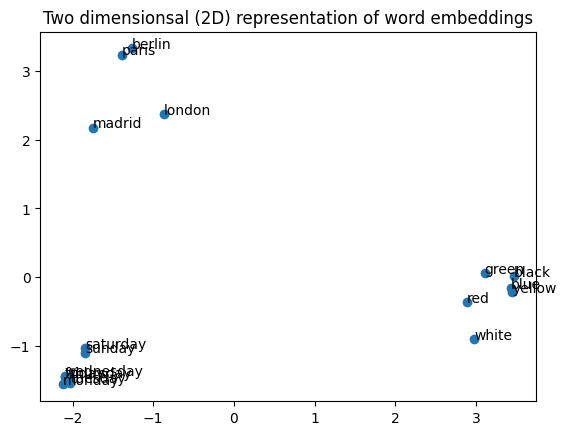

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

dir_root = '/content/drive/MyDrive/PredictNextWords'
glove_dir = 'glove/glove.6B'
glove_file = 'glove.6B.50d.txt'
# Load GloVe embeddings
word_embeddings = {}
with open(f'{dir_root}/{glove_dir}/{glove_file}', "rb") as f:
    for line in f:
        values = line.split()
        word = values[0].decode('utf-8')
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs

# Define words to compare
words = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
         'paris', 'london',  'berlin', 'madrid', 'red', 'blue', 'green', 'yellow', 'black', 'white']

# Get their corresponding embeddings
word_vectors = [word_embeddings[w] for w in words]

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(word_vectors)

# Plot the 2D embeddings
x = pca_vectors[:, 0]
y = pca_vectors[:, 1]
fig, ax = plt.subplots()
ax.scatter(x, y)

# Add labels to the scatter plot
for i, word in enumerate(words):
    ax.annotate(word, (x[i], y[i]))
plt.title('Two dimensionsal (2D) representation of word embeddings')
plt.show()


Another interesting thing we can do with word embeddings is perform mathematical operations on the vectors whilst still preserving the meaning of the words. For example, assuming that these high dimensional vectors preserve meaning well, the distance between a *'boy'* and a *'girl'* should be similar to the distance between a *'king'* and a *'queen'*.

Moreover, the vector obtained with *'queen'* - *'girl'* + *'boy'* should be similar to the vector of *'king'*. Lets check if these statements are true below.

Cosine similarity between the king vector and the queen-girl+boy vector:  1.0000001


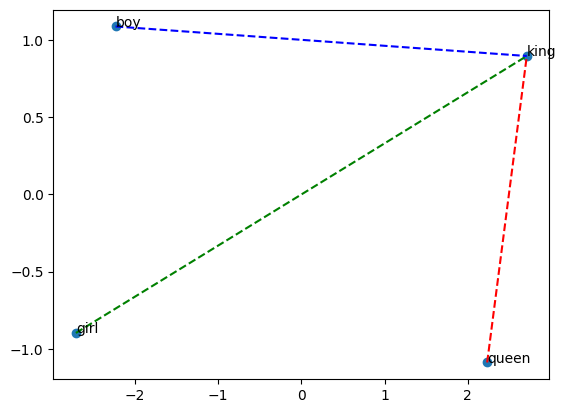

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# load glove embeddings again
word_embeddings = {}
with open(f'{dir_root}/{glove_dir}/{glove_file}', "rb") as f:
    for line in f:
        values = line.split()
        word = values[0].decode('utf-8')
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs

# Define the words to perform the operation on
# Define the words to perform the operation on
queen_vec = word_embeddings['queen']
girl_vec = word_embeddings['girl']
boy_vec = word_embeddings['boy']
king_vec = queen_vec - girl_vec + boy_vec

# Calculate cosine similarity between the king vector and the "queen - girl + boy" vector
cosine_sim = np.dot(king_vec, (queen_vec - girl_vec + boy_vec)) / \
    (np.linalg.norm(king_vec) * np.linalg.norm(queen_vec - girl_vec + boy_vec))

print("Cosine similarity between the king vector and the queen-girl+boy vector: ", cosine_sim)

# Get the corresponding embeddings
word_vectors = [queen_vec, girl_vec, boy_vec, king_vec]

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(word_vectors)

# Plot the 2D embeddings
x = pca_vectors[:, 0]
y = pca_vectors[:, 1]
fig, ax = plt.subplots()
ax.scatter(x, y)

# Add lines connecting the "queen", "girl", "boy", and "king" points
ax.plot([x[0], x[3]], [y[0], y[3]], 'r--')
ax.plot([x[1], x[3]], [y[1], y[3]], 'g--')
ax.plot([x[2], x[3]], [y[2], y[3]], 'b--')

# Add labels to the scatter plot
words = ['queen', 'girl', 'boy', 'king']
for i, word in enumerate(words):
    ax.annotate(word, (x[i], y[i]))

plt.show()


As we can see, the value of *cosine similarity* $ = \frac{(A . B)}{(||A|| ||B||)} = 1$ which indicates that the two vectors are identical. -1 would indicate oposite directions whilst 0 would indicate orthogonal vectors.


Finally, we can use the pre-trained GloVe word vectors are as a form of pretrained word embeddings in our model. Below I have written code that loads the GloVe vector and creates an embeddings matrix which we will use as the weights of our embedding layer in our model.

The embeddings matrix is of shape (V, GD) where V is the size of the vocabulary and GD is the dimensionality of the GloVe vectors. Thus, the embedding layer will have an input dimension of V and an output dimension of GD. The weights of the embedding layer will be initialized with the embeddings matrix. This means that the embedding layer will not be trained and will only be used to map the input tokens to their corresponding GloVe vectors. In the embedding matrix, ith row corresponds to the ith vector in our word index dictionary.

In [26]:
def load_glove(word_index, root_dir = "", glove_dir='glove/glove.6B', embedding_dim=50):
    """Loads the GloVe embedding matrix.

    Parameters
    ----------
    word_index : dict
        A dictionary with the word index. E.g. {'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5}
    glove_dir : str, optional
        The directory where the GloVe embeddings are stored, by default 'glove/glove.6B'.
        Can be downloaded from https://nlp.stanford.edu/projects/glove/.
    embedding_dim : int, optional
        The dimension of the GloVe embeddings, by default 50

    Returns
    -------
    embedding_matrix : np.array
        A numpy array with the embedding matrix. Dimensions: (num_words, embedding_dim)
        Used to initialize the embedding layer in the model. ith row corresponds to the ith vector in the word_index.
    """

    import os
    import numpy as np

    try:
        embeddings_index = {}
        f = open(f'{root_dir}/{glove_dir}/glove.6B.{embedding_dim}d.txt', encoding='utf-8')
        for line in f:  # Each line is a word and its embedding vector
            values = line.split()
            word = values[0]
            # The embedding vector
            coefs = np.asarray(values[1:], dtype='float32')
            # Add the word and its embedding vector to the dictionary
            embeddings_index[word] = coefs
        f.close()

        print(f'\nLoaded glove. Found {len(embeddings_index)} word vectors.')

        # prepare embedding matrix
        # The number of words in the word_index + 1 (for the 0th index)
        num_words = len(word_index) + 1
        embedding_matrix = np.zeros((num_words, embedding_dim))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                # ith row corresponds to the ith vector in the word_index
                embedding_matrix[i] = embedding_vector
        print(
            f'Created embedding matrix. Dimensions: {embedding_matrix.shape}.')
        return embedding_matrix
    except Exception as e:
        print('Error occured:', e)


## Previous model: Stacked LSTMs

### The text below is directly copied from the previous paper and is here for contextual and comparison purposes. You can skip directly to "Improved architecture: Sequence to Sequence with Attention and LSTM" for the new architecture.



### RNNs

To understand LSTMs we must firstly have some understanding of what RNNs are. They are neural networks architecture designed to process sequential data such as text, time-series data, speech, etc. We call them recurrent because they operate as sort of a feedback loop allowing information from one tep in the sequence to be passed and used in the next step, which makes them great for sequential data and data of variable length.

Below we have a visualization of a RNN courtesy of Towards AI.

![RNN](https://drive.google.com/uc?export=view&id=1ikuY6gDEWqPvmYiI2f8aHmKaHLoHQBwE)

They are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations.

Now, the vanishing gradient problem happens when the gradients become too small and close to 0 to be of any use for updating the weights of the network. As such, the network becomes unable to learn any long-term dependencies in the data since the information from the very early time steps is lost as the information gets propagated forward through the network. Consequently, RNNs may perform on tasks that require long-term memory, which we frequently need when analyzing time series or text.

Mathematically, the vanishing gradients happen due to backpropagation. Specifically, we take the gradient of the loss function with respect to the weights in the network and multiply it by the gradient of the activation function with respect to the output of the previous layer. This is repeated for every layer in the network. Sometimes these derivatives are small (for example - when we have a sigmoid function as the activation function) and they become even smaller as we multiply them by the gradients of the previous layers. This means that the gradients get smaller and smaller and as the result the weights of the network are not updated properly and the network is unable to learn long-term dependencies.


I have decided to use an LSTM (Long Short-Term Memory) model architecture which is a type of recurrent neural network (RNN) architecture designed to model sequential data. It has been developed and mitigate the problem of vanishing gradients in vanilla RNNs.


### LSTM
To mitigate this problem, [Hochreiter, S., & Schmidhuber, Jurgen. (1997)](https://www.bioinf.jku.at/publications/older/2604.pdf) introduced Long Short-Term memory.

![LSTM](https://drive.google.com/uc?export=view&id=1rVs_-qYcEY0cLMc1Iri5GsNUs_JUn1OX) Visualization by [Saul Dobilas](https://towardsdatascience.com/lstm-recurrent-neural-networks-how-to-teach-a-network-to-remember-the-past-55e54c2ff22e).

In the LSTM, every time step of the input sequence is processed by a cell consisting of several important components:

1. *Input gate* - controls what information from the input sequence is passed to the cell state.
$ i_t = \sigma(W_{xi}x_t + U_{hi} \times h_{t-1} + b_i) $
2. *Forget gate* - controls what information from the cell state is passed to the next time step.
$ f_t = \sigma(W_{xf}x_t + U_{hf} \times h_{t-1} + b_f) $
3. *Output gate* - controls what information from the cell state gets passed to the output sequence.
$ o_t = \sigma(W_{xo}x_t + U_{ho} \times h_{t-1} + b_o) $
4. *Memory cell* - stores the information about the input sequence. Can be thought of as a conveyor belt that carries information from one time step to the next whilst selectively removing or adding information to the cell state.
$ \tilde{C}_t = f_t \times c_{t_1} + i_t \times \tanh(W_cx \times x_t + U_ch \times h_{t-1} + b_c)$
5. *Hidden state* - the output of the LSTM cell and is passed to the next time step.
$ h_t = o_t \times \tanh(\tilde{C}_t)$


$x_t$ is the input to the cell at time step $t$, $h_{t-1}$ is the hidden state from the previous time step, $i_t$ is the input gate at $t$, $f_t$ is the forget gate at $t$, $o_t$ is the output gate at $t$, $c_{t-1}$ is the cell state from the previous time step, $\tilde{C}_t$ is the cell state at $t$, $h_t$ is the hidden state at $t$.

$W_{xi}$, $W_{xf}$, $W_{xo}$, $W_{xc}$ are the weights of the input gate, $U_{hi}$, $U_{hf}$, $U_{ho}$, $U_{hc}$ are the weights of the hidden state, $b_i$, $b_f$, $b_o$, $b_c$ are the biases of the gates.

The input gate $i_t$ controls how much of the new input $x_t$ should be added to the cell state $c_{t-1}$. The forget gate $f_t$ controls how much of the previous cell state $c_{t-1}$ should be retained and passed on to the nexts time step, and how much should be discardedd. The output gate $o_t$ controls how much of the cell state $c_t$ should be output to the next layer or the final output of the network.

The memory cell $c_t$ is updated based on the input $x_t$, the previous cell state $c_{t-1}$, and the values of the input and forget gates. The tanh function introduces nonlinearity and allows the model to capture more complex patterns in the data.

The hidden state $h_t$ is the final output of the LSTM cell, and is calculated by applying the output gate to the current cell state $c_t$ and passing the result through the tanh function. The hidden state can be used as the input to the next LSTM cell in the sequence or as the final output of the network.

Going back to the vanishing gradient problem, LSTMs mitigate it through the memory cell explained above which controlls the input, forget and the output gate and allows the model to retain information for a long time. Moreover, since the gates use sigmoid and tanh activation function, the values are always between 0 and 1 allowing control of information through the memory cell without them being too small or too large.



#### Training the LSTM

To train them, we use regular backpropagation with the goal of minimizing the loss that measures the difference between the the predictions and true output for the given input. Important aspect of sequential dat is that both the input and the output have a temporal relationship which must not be broken.  Typically, we use a metric such as a mean squared error or, in this case, categorical cross entropy loss, since our goal is to predict the probability distribution over the vocabulary (categorical variable) given the previous words in the sentence.

The loss function is calculated as follows:
$$H(p, q) = -\sum_{i} p(i) \log q(i)$$

where $p$ is the true probability distribution over the categories and $q$ is the predicted probability distribution over the categories. In our case, $p$ is the one-hot encoded vector of the true word (1 for the target word and 0 for all others) and $q$ is the probability distribution over the vocabulary.

The negative sign in the equation ensures that the loss is minimized by increasing the predicted probability of the true word and decreasing the predicted probabilities of all other words.

By minimizing the categorical cross-entropy loss during training, the model learns to predict the correct probability distribution over the vocabulary given the previous words in the sentence allowing the model to generate more accurate predictions.

This model is fully implemented under the function *train_lstm* below.

The function *train_lst* below is used to train the model. The model has the following layers. Stacking two LSTM layers next to one another greatly improved my performance. The final layers is a softmax layer since it gives us the probability distribution over the vocabulary.


The layer hyperparameters were chosen based on the tuning I did through the validation set. The following hyperparameters yielded the greatest validation accuracy.

The following code includes several additional features. I have added both early stopping and model checkpointing. Early stopping is used to prevent overfitting by stopping the training process when the validation loss stops improving. Model checkpointing is used to save the model with the best validation accuracy.

I have also added dropout layers to prevent overfitting. This is a regularization technique that randomly drops out units (along with their connections) from the neural network during training. This prevents units from co-adapting too much.

Besides dropout layers I have also added an l2.regularizer. This is a regularization technique that adds a penalty to the loss function for large weights. This helps prevent overfitting by forcing the model to learn smaller weights.

For the optimizer, I used Adam with the learning rate of 0.001 which proved the best in the validation set. Adam is preferred here to a static learning rate since it has an adaptive learning rate that changes for each parameter. This allows the model to converge faster and more efficiently. It also incorporates momentum by updating the moving average of the gradient and the moving average of the squared gradient once again leading to faster convergence and also helping in leaving local optima.



In [27]:
def train_lstm(word_index, embedding_matrix, X_train, X_test, X_val, y_train, y_test, y_val, epochs=100, batch_size=256, lr=0.001, embedding_dim=100, seq_len=30, dropout_rate=0.2, weight_decay=1e-4):
    """
    Trains the LSTM model. It also saves the model and the history as well as

    Parameters
    ----------
    word_index : dict
        A dictionary with the word index. E.g. {'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5}
    embedding_matrix : np.array
        A numpy array with the embedding matrix. Dimensions: (num_words, embedding_dim)
    epochs : int, optional
        The number of epochs to train the model, by default 100
    X_train : list
        A list of training features.
    X_test : list
        A list of testing features.
    X_val : list
        A list of validation features.
    y_train : list
        A list of training targets.
    y_test : list
        A list of testing targets.
    y_val : list
        A list of validation targets.
    batch_size : int, optional
        The batch size, by default 256
    lr : float, optional
        The learning rate, by default 0.001
    embedding_dim : int, optional
        The dimension of the GloVe embeddings, by default 100
    seq_len : int, optional
        The length of the sequences, by default 30
    dropout_rate : float, optional
        The dropout rate, by default 0.2
    weight_decay : float, optional
        The weight decay, by default 1e-3

    Returns
    -------
    model : keras model
        The trained model.
    """

    from keras.models import Sequential
    from keras.layers import Embedding, LSTM, Dense, Dropout
    from keras.optimizers import Adam
    from keras.callbacks import ModelCheckpoint, EarlyStopping
    from keras import regularizers
    from pickle import dump
    from keras.utils.vis_utils import plot_model

    num_words = len(word_index) + 1  # +1 because of the 0 index

    print("\nStarting LSTM model training...")

    model = Sequential()
    model.add(Embedding(num_words, embedding_dim, weights=[
        embedding_matrix], input_length=seq_len, trainable=False))
    model.add(LSTM(units=50, return_sequences=True,
              kernel_regularizer=regularizers.l2(weight_decay)))  # used to prevent overfitting by adding a penalty to the loss function
    model.add(Dropout(dropout_rate))  # used to prevent overfitting
    model.add(LSTM(50, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Dropout(dropout_rate))  # used to prevent overfitting
    model.add(Dense(50, activation='relu',
              kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Dense(num_words, activation='softmax'))
    plot_model(model, to_file='model_plot.png',
               show_shapes=True, show_layer_names=True)
    model.summary()

    # compile model
    my_opt = Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer=my_opt,
                  metrics=['accuracy'])

    checkpoint_path = "training_1"

    # Create a callback that saves the model's weights
    cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                  save_weights_only=True,
                                  verbose=0,
                                  save_freq='epoch')
    # patience is the number of epochs to wait before stopping, if the model is not improving.
    earlystopping = EarlyStopping(
        monitor='val_accuracy', verbose=0, patience=3, restore_best_weights=True)

    import numpy as np
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # fit model
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
    history = model.fit(X_train, y_train, validation_data=(
        X_val, y_val), batch_size=batch_size, epochs=epochs, shuffle=True, callbacks=[earlystopping, cp_callback])

    # save the model to file
    model_name = f"saved_models/lstm_{embedding_dim}d_{seq_len}seq_{epochs}epochs_{lr}lr_{batch_size}batch.h5"
    model.save(model_name)
    history_name = f"saved_models/lstm_{embedding_dim}d_{seq_len}seq_{epochs}epochs_{lr}lr_{batch_size}batch_history.pkl"
    dump(history.history, open(history_name, 'wb'))

    # evaluate model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print()
    print('Test Loss: %f' % (loss))
    print('Test Accuracy: %f' % (accuracy))

    return model, history


## Improved architecture: Sequence to Sequence with Attention and LSTM

### LSTM limitations

To understand the proposed architecture, we must firstly understand the limitations of the architecture that we used in the previous project - LSTMs.

Up until the publishing of
[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) by Bahdanau et al. RNNs, LSTMs and GRUs were considered the state of the art for most, if not all, sequence tasks.

Note: GRUs that are more simplified versions of LSTMs that have only two gates: the reset gate and the update gate, which tend to achieve similar or better results to LSTMs with less parameters and faster training times.


However, Bahdanau et al. showed an architecture that is a stepping stone into some of the state-of-the-art techniques, such as transformers (famous paper "Attention is all you need" directly came out of the abovementioned paper), GPT models, etc.

To understand the need for this model, we must firstly understand the limiations with the model we developed previously.

Firstly, LSTMs still have difficulty in modeling long-term dependencies despite them being developed to address the vanishing gradient problem in traditional RNNs. However, testings we have done have shown that even LSTMs (even powerful ones that are stacked like we did) were ineffective in capturing long-term dependencies effectively, especially when the gap between the current word and the predicted word is large. This is especially true in the case of many-to-many relationships (we are doing many-to-one since we are just predicting the next word).

Perhaps not really applicable to our case, but LSTMs require fixed length input sequences meaning that sentences that are much shorter or much longer than the ones the LSTMs have been trained one will give poor results since they will have to be cut off or padded with 0s.

Most importantly, LSTMs lack context. Since their underlining architecture they still process each word isolation without really having an understanding of its context (we humans are amazing at remembering that "He" refers to "Mark" in the sentences "Mark bought a car. He loves it"). LSTMs are not really good at paying *attention* at these things, especially in very large texts, leading to poor results, especially in cases where there might be sublety and many interpretations.



### Sequence to Sequence or the Encoder Decoder structure

Much like a normal Encoder-Decoder strucutre, the vanilla Seq2Seq model has two parts:

1. **Encoder**: takes in the sequence of words $(x1, x2, ..., xn)$ and encodes it in a fixed length vector $(c)$ which captures the meaning as best as possible. This is usually done through an LSTM or GRU cell much like we did above. The encoder hidden state $(h_i)$ at each time step $i$ is calculated as follows:

$$h_i = LSTM(x_i, h_i-1)$$

The final encoder output $(c)$ is the last hidden state of the encoder:
$c = h_n$

2. **Decoder**: generates the output sequence $(y1, y2,..,ym)$ (which in our case it would be just a single word) based on the context vector $(c)$ that the encoder encoded.

The decoder's hidden state $(s_j)$ at time $j$ given $$s_j = LSTM(y_j-1, s_j-1)$$
where $(s_j-1)$ is the hidden state $(y_j-1)$ is the previously predicted word

The context vector $(c)$ is used to initialize the first hidden state $(s_0)$ of the decoder:

$s_0 = c$

The predicted output $(y_j)$ at each time step is obtained by passing the decoder hidden state $(s_j)$ through a softmax activation function:

$$y_j = softmax(Ws_j + b)$$

where $W$ and $b$ are learnable weights and biases.

In the case of natural language translation from English to German, this is how the architecture looks.

![](https://drive.google.com/uc?export=view&id=1F_7qZs34F7w8S6eXN8py7oqNZnavfh7q)

Mathematically, the encoder-decoder structure tries to approximate the mapping from one sequence to another (in our case, just to the next word). It learns to do so through supervised method by minimizing the difference between the predicting made with the decoder and the targets.

The training is done by minimizing the cross-entropy loss through backpropagation and gradient descent:

$$L = -\sum_{j=1}^{m} [y_j^* \log(y_j) + (1-y_j^*)\log(1-y_j)]$$

where $y_j^*$ is the one-hot encoded target output at time step $j$, and $y_j$ is the predicted output at time step $j$.


#### Limitations

Unfortunately, even this architecture has its limitations similar to the vanilla LSTM. It also has problems dealing with long-term dependencies and it pays attention to every word in the input with equal importance when generating the output.  Interestinly, since the Seq2Seq model is trained to generate the next word given the ground-truth previous words, the model generates the previous predicted words instead of the ground-truth words, which oftentims leads to a compounding error known as exposure bias.

To combat this, we introduce the concept of attention.


![](https://drive.google.com/uc?export=view&id=1pHC636KJLLO7cuDc-jSSOaV2YIip6NBJ)

Attention is essentially comprised of the following three steps:

1. We calculate the scalar attention score between each decoder hidden state $(s_i)$ and each encoder hidden state $(h_j)$, which measures the relevance of the encoder token $j$ for predicting the decoder token $i$:
$$a_{i,j} = \frac{\text{exp}(s_i \cdot h_j)}{\sum_k \text{exp}(s_i \cdot h_k)}$$
where $s_i$ and $h_j$ are the decoder and encoder hidden states at time step i and j respectively, and $a_{i,j}$ is the attention score for decoder token i and encoder token j.

2. Normalize the attention scores using a softmax function to obtain a probability distribution over the encoder tokens, which represent the importance of each token for predicting the next word:
$$w_{i,j} = \frac{\text{exp}(a_{i,j})}{\sum_k \text{exp}(a_{i,k})}$$
where $w_{i,j}$ is the attention weight for decoder token i and encoder token j

3. Finally, calculate the weighted sum of encoder hidden states with attention weights and feed it into the next decoder cell:
$$c_i = \sum_j w_{i,j} h_j$$
where $c_i$ is the context vector for decoder token i.


This structure provides much better results since it allows the decoder to selectively focus on the most important parts of the input sequence allowing it to better capture long term dependencies, better handle variable length input sequences. It is also more interpretable since we can visualize which part of the input sequence are most inportant (we just look at the weight associated with each word)


### Loss function

Since we essentially have a multi-class classification problems where the labels are the indexes in the vocabulary rather than one-hot encoded vectors like we had last time, we can use **Sparse categorical crossentropy**:

$$L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{i,j} \log(p_{i,j})$$

where $N$ is the batch size, $C$ is the number of classes (words in this case - *vocabulary size*), $y_{i,j}$ is 1 if the true label of sample $i$ is class $j$ and 0 otherwise, and $p_{i,j}$ is the predicted probability of sample $i$ being in class $j$.

### Evaluation metrics

As opposed to just the accuracy which only looks at the number of correctly made predictions out of total predictions, we will be using more sophisticated metrics. Accuracy is not sufficient since we can have a prediction that is good and reasonable but is not the one found in the training set. For example: *"Today is a"* can be followed by any of the following ["great", "good", "rainy", etc.]. Rather than just labelling all predictions but the target as incorrect, we can be more intelligent and look at if they actually make sense.

To accomplish that, we shall use the following metrics:

1. **Accuracy**: $$Accuracy = \frac{number\ of\ correctly\ predicted\ words}{total\ number\ of\ predicted\ words}$$

2. **Top-k accuracy**: <br> Count the prediction as correct if the target word is within the top k predictions made (top k most probable words) by the model.
$$top\ k\ accuracy = \frac{number\ of\ correctly\ predicted\ words\ in\ top\ k\ predictions}{total\ number\ of\ predicted\ words}$$
3. **Perplexity**: Perplexity is one of the most common metrics used in text generation to evaluate the quality of a language model by measuring how well it predicts a sample of previously unseen text.
$$\text{Perplexity} = e^{H(y_{true}, y_{pred})} = e^{-\frac{1}{N}\sum_{i=1}^{N} \log P(y_{true}^{(i)} | x^{(i)}, \theta)}$$
where $y_{true}$ is the true label, $y_{pred}$ is the predicted label, $N$ is the number of samples in the dataset, $x^{(i)}$ is the $i$-th input sample, and $\theta$ are the model parameters. <br>
It is just the exponentiated *cross-entropy loss* between the true and predicted labels $H(y_{true}, y_{pred})$:
$$H(y_{true}, y_{pred}) = -\sum_{c=1}^{C} y_{true,c} \log y_{pred,c}$$,where $C$ is the number of classes, $y_{true,c}$ is the true probability of the $c$-th class, and $y_{pred,c}$ is the predicted probability of the $c$-th class.

4. **Cosine similarity**: This is something that is not usually used but I believe we can look at where the predicted word is located in the multidimensional vector space by looking at its embedding and then comparing how similar it is to the vector of the true label in that vector space using cosine similarity:
$$\text{cosine_similarity}(A, B) = \frac{A \cdot B}{\left\Vert A \right\Vert \left\Vert B \right\Vert}$$
where $A$ and $B$ are the two vectors being compared, and $\left\Vert A \right\Vert$ and $\left\Vert B \right\Vert$ represent the Euclidean lengths (magnitude) of vectors $A$ and $B$, respectively. The dot product of vectors $A$ and $B$ is represented by $A \cdot B$.

### Model architecture

Drawing from the explanation above, our model architecture will be slightly modified for our task and will consist of (visualization available below):
1. **input layer**: takes in the 100 word sequence $(w_1, w_2, \dots, w_{100})$ as input. Output is tensor of shape: $[(None, 100)]$
2. **embedding layer**: takes in the inputs and converts them to their 50-dimensional pre-trained GloVe embeddings. These become the initial weights. Interesting, setting these to be trainable (which is not usually done) gives around a 1.5% increase in accuracy. I presume this is becasue of the small dataset which has its own quirky distribution.  Output is tensor of shape: $[(None, 100, 50)]$
3. **the encoder**: comprises of an LSTM cell that also has an L2 regulizer, and a weight dropout layer to prevent overfitting. It returns the output sequences for each timestep and not only the final one to allow the decoder to have access to the entire input sequence, which is necessary for generating the correct output sequence. Output is tensor of shape: $[(None, 100, 50)]$
4. **the decoder**: comprises of an LSTM cell that also has an L2 regulizer, and a weight dropout layer to prevent overfitting. However, it returns only the output of the last timestep, rather than the output sequence of all timesteps. This is then added with the updated context vector from the attention layer (in the concatenation layer later). Output is tensor of shape: $[(None, 50)]$.
5. **the attention layer**: Comprising of a custom attention layer which we will define below (this is because we can not use the ones available in Keras since they are made only for long sequence generation and not for just a single word). The attention layer will take the output of the *encoder* and *decoder* and will produce the context vector which will be a tensor of shape: $[(None, 50)]$
6. **the concatenation layer**: sums the attention context vector and the decoder hidden state (its output) as explained above. Output is tensor of shape: $[(None, 100)]$
7. **dropout layer**: attaches to the concatenation layer and randomly sets a fraction of the input units to zero, which effectively drops them out of the network for that training epoch thereby reducing overfitting. Output is tensor of shape: $[(None, 100)]$
8. **the dense layer**: this is just a regular dense layer with softmax activation function applied to it so we get a probability distribution for each word. The index with the highest value represent the word with the highest probability of being the next word. As such, its output is tensor of shape: $[(None, Vocabulary \text{ } size)]$

Below is the final architecture of the model including the inputs and outputs of each layer that also showcases the changes in dimensionality.
![](https://drive.google.com/uc?export=view&id=1fzGpkUeqBEwzvQNt2_S9jYgMsggeJsuN)


The code for the arcitecture above is implemented in the cell below.

In [28]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate, TimeDistributed, Attention
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras.utils import plot_model
from pickle import dump

def seq2seq_with_attention(word_index, embedding_matrix, X_train, X_test, X_val, y_train, y_test, y_val, epochs=100, batch_size=256, lr=0.001, embedding_dim=100, seq_len=30, dropout_rate=0.2, weight_decay=1e-4, root_dir=""):
    """
    Trains a Sequence to Seqence with Attention and LSTMs model for next word prediction.
    It predicts only a single word (the next word y_1) and not a sequence of words (y_1, y_2, y_3, y_4).


    Parameters
    ----------
    word_index : dict
        A dictionary with the word index. E.g. {'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5}
    embedding_matrix : np.array
        A numpy array with the embedding matrix. Dimensions: (num_words, embedding_dim)
    epochs : int, optional
        The number of epochs to train the model, by default 100
    X_train : list
        A list of training features. Shape: (num_samples, seq_len)
    X_test : list
        A list of testing features. Shape: (num_samples, seq_len)
    X_val : list
        A list of validation features. Shape: (num_samples, seq_len)
    y_train : list
        A list of training targets. Shape: (num_samples, ). It is a list of indices that correspond to the next word for each sequence.
    y_test : list
        A list of testing targets. Shape: (num_samples, ).
    y_val : list
        A list of validation targets. Shape: (num_samples, )
    batch_size : int, optional
        The batch size, by default 256
    lr : float, optional
        The learning rate, by default 0.001
    embedding_dim : int, optional
        The dimension of the GloVe embeddings, by default 100
    seq_len : int, optional
        The length of the sequences, by default 30
    dropout_rate : float, optional
        The dropout rate, by default 0.2
    weight_decay : float, optional
        The weight decay, by default 1e-3
    root_dir : str, optional
        The root directory, by default ""
        In case of Google Colab, the root directory is "/content/drive/My Drive/"

    Returns
    -------
    model : keras model
        The trained model.
    history : dictionary
        A dictionary containing the training history of the model.
    """

    def custom_attention():
        """
        Since most Attention function available in Keras only works for predicting long sequences,
        we need to create a custom attention layer that works for predicting a single word.

        We use the Bahdanau Attention mechanism as described in the paper
        "Neural Machine Translation by Jointly Learning to Align and Translate"
        by Dzmitry Bahdanau, Kyunghyun Cho, and Yoshua Bengio.

        """
        # inherit from the super class tf.keras.layers.Layer (gives us access to the add_weight() method
        class CustomAttention(tf.keras.layers.Layer):
            def __init__(self):
                """
                Initialize the layer.
                """
                super(CustomAttention, self).__init__()  # call the super class constructor and initialize the layer

            def build(self, input_shape):
                """
                Initialize the weights of the layer. self.add_weight() is inherited from the super class tf.keras.layers.Layer.

                W1 and W2 are the weights of the encoder and decoder respectively. Shape = (embedding_dim, embedding_dim)
                V is the weight of the attention layer.

                They are initialized with the Glorot uniform initializer because it is recommended for RNNs as per the paper
                "Understanding the difficulty of training deep feedforward neural networks" by Xavier Glorot and Yoshua Bengio.

                Parameters
                ----------
                input_shape : tuple
                    A tuple containing the input shape.

                Returns
                -------
                None
                """
                self.W1 = self.add_weight(shape=(
                    input_shape[0][-1], input_shape[0][-1]), initializer='glorot_uniform', name='W1')  # add the weight to the layer
                self.W2 = self.add_weight(shape=(
                    input_shape[1][-1], input_shape[1][-1]), initializer='glorot_uniform', name='W2')  # add the weight to the layer
                self.V = self.add_weight(
                    shape=(input_shape[0][-1], 1), initializer='glorot_uniform', name='V')  # add the weight to the layer

            def call(self, inputs):
                """
                Compute the context vector and return it.
                The context vector is calculated by

                Parameters
                ----------
                inputs : list (tf.tensor, tf.tensor) represetning (encoder_outputs, decoder_hidden)
                    A list containing the encoder outputs and decoder hidden state.
                    The encoder outputs are the outputs of the encoder LSTM.
                    The decoder hidden state is the output of the decoder LSTM.

                Returns
                -------
                context_vector : tf.tensor
                    The context vector.
                """
                encoder_outputs, decoder_hidden = inputs  # unpack the inputs
                # expand the dimension of the decoder hidden state to match the encoder outputs
                decoder_hidden = tf.expand_dims(decoder_hidden, 1)
                # compute the scalar attention score: tanh(W1*encoder_outputs + W2*decoder_hidden)
                score = tf.nn.tanh(
                    tf.matmul(encoder_outputs, self.W1) + tf.matmul(decoder_hidden, self.W2))
                # normalize the attention scores using a softmax function to obtain a probability distribution over the encoder tokens
                attention_weights = tf.nn.softmax(
                    tf.matmul(score, self.V), axis=1)
                # compute the context vector by multiplying the attention weights with the encoder outputs and summing them up
                context_vector = attention_weights * encoder_outputs
                context_vector = tf.reduce_sum(context_vector, axis=1)

                return context_vector
        return CustomAttention()  # return the layer

    def top_k_accuracy(y_true, y_pred):
        """
        Compute the top k accuracy of the model using sparse categorical crossentropy (for one-hot encoded labels)
        A prediction is considered accurate if the true label is in the top k predictions.

        Parameters
        ----------
        y_true : tf.tensor. shape: (batch_size, 1)
            batch_size is the number of samples in a batch. Each element is an integer representing the index of the true class.
        y_pred : tf. tensor. shape: (batch_size, vocab_size).
            each row is a probability distribution over the vocab_size, summing to 1.
            The index of the maximum value in each row is the predicted class.

        Returns
        -------
        Sparse top K categorical accuracy value. Float between 0 and 1.
        """

        from keras.metrics import sparse_top_k_categorical_accuracy

        top_k = 5  # top 5 accuracy
        return sparse_top_k_categorical_accuracy(y_true, y_pred, k=top_k)

    def perplexity(y_true, y_pred):
        """
        Compute the perplexity of the model using sparse categorical crossentropy (for one-hot encoded labels)
        Perplexity is just exponentiated categorical crossentropy or the average negative log-likelihood of a sequence of words.

        In the case of predicting a single word, there is no context or sequence of words to evaluate the language model against.
        The model is simply making a prediction based on a single input token.
        Therefore, calculating perplexity for a single word prediction would not be meaningful because it does not capture the
        ability of the model to predict future words in the sequence. Thus, it is expected that the perplexity of the model would
        be increasing rapidly as the model is trained.

        Parameters
        ----------
        y_true : tf.tensor. shape: (batch_size, 1)
            batch_size is the number of samples in a batch. Each element is an integer representing the index of the true class.
        y_pred : tf. tensor. shape: (batch_size, vocab_size).
            each row is a probability distribution over the vocab_size, summing to 1.
            The index of the maximum value in each row is the predicted class.

        Returns
        -------
        perplexity : float
            The perplexity of the model.
        """

        import keras.backend as K

        cross_entropy = K.sparse_categorical_crossentropy(
            y_true, y_pred)  # compute the sparse categorical crossentropy
        # exponentiate the crossentropy to obtain the perplexity
        perplexity = K.exp(cross_entropy)
        return perplexity


    def wrapped_cosine_similarity(embedding_matrix):
        """
        Compute the cosine similarity between the true and predicted labels.

        The reason why this is wrapped into another function is because of
        how the custom metrics are implemented in Keras. Since I have to pass
        the embedding matrix to this metric, I have to wrap it into a metric
        as per https://stackoverflow.com/a/71422348

        Parameters
        ----------
        y_true : tf.tensor. shape: (batch_size, 1)
            batch_size is the number of samples in a batch. Each element is an integer representing the index of the true class.
        y_pred : tf. tensor. shape: (batch_size, vocab_size).
            each row is a probability distribution over the vocab_size, summing to 1.
            The index of the maximum value in each row is the predicted class.
        embedding_matrix: tf.tensor. shape: (vocab_size, embedding_dim)
            Embedding matrix of vocabulary size and embedding dimension

        Returns
        -------
        cosine_similarity : float (between -1 and 1)
            The cosine similarity between the true and predicted labels.
        """

        def cosine_similarity(y_true, y_pred):
          # get the index of the maximum value in each row of y_pred
          y_pred = tf.argmax(y_pred, axis=1)

          # convert y_true to int32 data type
          y_true = tf.cast(y_true, dtype=tf.int32)

          # expand the dimensions of y_true and y_pred
          y_true = tf.expand_dims(y_true, -1)
          y_pred = tf.expand_dims(y_pred, -1)

          # get the embedding of the true and predicted labels
          y_true = tf.nn.embedding_lookup(embedding_matrix, y_true)
          y_pred = tf.nn.embedding_lookup(embedding_matrix, y_pred)

          # compute the cosine similarity between the true and predicted labels
          numerator = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=1)
          denominator = (tf.sqrt(tf.reduce_sum(tf.square(y_true), axis=1)) *
                        tf.sqrt(tf.reduce_sum(tf.square(y_pred), axis=1)))
          cosine_similarity = tf.where(tf.math.is_finite(numerator / denominator),
                                      numerator / denominator,
                                      tf.zeros_like(numerator))

          # normalize the cosine similarity to be between -1 and 1
          cosine_similarity = tf.clip_by_value(cosine_similarity, -1.0, 1.0)
          return tf.reduce_mean(cosine_similarity)

        return cosine_similarity

    def build_model():
        """
        Builds the model consisting of:
        - the embedding layer (converts the inputs into pretrained GloVe embeddings); trainable weights give better results
        - the encoder (comprising of an LSTM cell),
        - the decoder (comprising of an LSTM cell),
        - the attention layers (comprising of a custom attention layer defined above connecting the encoder and decoder),
        - the concatenation layer (the attention context vector + decoder hidden state),
        - dropout layer (comprising of dropout layer to prevent overfitting), attaches to the concatenation layer
        - the dense layer (comprising of a dense layer with softmax activation function), attaches to the dropout layer\

        Loss function: sparse categorical crossentropy (for one-hot encoded labels)
        Optimizer: Adam
        Metrics: accuracy, top k accuracy, cosine similarity, perplexity
        Both LSTM cells have a dropout rate and a weight decay (L2 regularization)

        Prints the model summary and saves the model architecture as a png file.

        Returns
        -------
        model : tf.keras.Model
            The model.
        """

        # input Layer
        input_layer = Input(shape=(seq_len,))

        # embedding Layer (pre-trained GloVe embeddings), not trainable so that the weights are not updated during training
        embedding_layer = Embedding(input_dim=len(word_index) + 1,
                                    output_dim=embedding_dim,
                                    weights=[embedding_matrix],
                                    input_length=seq_len,
                                    trainable=True)(input_layer)

        # encoder: LSTM cell with dropout and weight decay (L2 regularization)
        encoder_lstm = LSTM(units=embedding_dim,
                            return_sequences=True,
                            dropout=dropout_rate,
                            kernel_regularizer=regularizers.l2(weight_decay))(embedding_layer)

        # decoder: LSTM cell with dropout and weight decay (L2 regularization)
        decoder_lstm = LSTM(units=embedding_dim,
                            return_sequences=False,
                            dropout=dropout_rate,
                            kernel_regularizer=regularizers.l2(weight_decay))(encoder_lstm)

        # attention Layer
        attention_layer = custom_attention()([encoder_lstm, decoder_lstm])
        concat_layer = Concatenate(axis=-1)([decoder_lstm, attention_layer])

        # dense layer
        dropout_layer = Dropout(rate=dropout_rate)(concat_layer)
        output_layer = Dense(len(word_index) + 1,
                             activation='softmax')(dropout_layer)

        # create the Model
        model = Model(inputs=input_layer, outputs=output_layer)

        # compile the Model
        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=Adam(learning_rate=lr),
                      metrics=['accuracy', top_k_accuracy, wrapped_cosine_similarity(embedding_matrix), perplexity])

        # model Summary
        print(model.summary())

        # plot the Model
        plot_model(model, to_file='model.png',
                   show_shapes=True, show_layer_names=True)

        return model

    def train_model(model):
        # making a model checkpoint every time the validation loss decreases
        checkpoint = ModelCheckpoint(
            filepath=f'{root_dir}/model_checkpoints/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        # stopping the training if the validation loss does not decrease for 'patience=10' epochs
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=10, verbose=1, mode='min')

        # train the model and saving the history
        history = model.fit(X_train, np.expand_dims(y_train, -1),
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val, np.expand_dims(y_val, -1)),
                            callbacks=[checkpoint, early_stopping],
                            verbose=1)  # expand the dimensions of the validation and training labels to match the model output

        # Load the best weights
        model.load_weights(f'{root_dir}/model_checkpoints/model.h5')

        return model, history

    def plot_results(history):
        """
        Plots the training and validation loss and accuracy.

        Parameters
        ----------
        history : keras history
            The history of the training.
        """
        import matplotlib.pyplot as plt

        # plot training and validation loss
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title('Training and validation loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

        # plot training and validation accuracy
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='validation')
        plt.title('Training and validation accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

        # plot training and validation top-5 accuracy
        plt.plot(history.history['top_k_accuracy'], label='train')
        plt.plot(history.history['val_top_k_accuracy'], label='validation')
        plt.title('Training and validation top-5 accuracy')
        plt.ylabel('Top-5 Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

        # plot training and validation cosine similarity
        plt.plot(history.history['cosine_similarity'], label='train')
        plt.plot(history.history['val_cosine_similarity'], label='validation')
        plt.title('Training and validation cosine similarity')
        plt.ylabel('Cosine Similarity')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

        # plot training and validation perplexity
        plt.plot(history.history['perplexity'], label='train')
        plt.plot(history.history['val_perplexity'], label='validation')
        plt.title('Training and validation perplexity')
        plt.ylabel('Perplexity')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

    # convert lists to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # build the model, train the model and plot the results
    model = build_model()
    trained_model, history = train_model(model)
    plot_results(history)

    # evaluate the Model
    loss, accuracy, top_k_accuracy, cosine_similarity, perplexity = model.evaluate(X_test, np.expand_dims(
        y_test, -1), batch_size=batch_size, verbose=1)

    # print the final test results
    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print("Test top-5 accuracy:", top_k_accuracy)
    print("Test perplexity:", perplexity)
    print("Test cosine similarity:", cosine_similarity)

    # give the model a name
    model_name = f"seq2seq_{embedding_dim}dGLOVE_{seq_len}seq_{epochs}epochs_{lr}lr_{batch_size}batch"

    # save the model
    trained_model.save(f'{root_dir}/saved_model/{model_name}.h5')
    # save the history
    model_name = f"seq2seq_{embedding_dim}dGLOVE_{seq_len}seq_{epochs}epochs_{lr}lr_{batch_size}batch"
    with open(f'{root_dir}/saved_histories/{model_name}.pkl', 'wb') as f:
        dump(history.history, f)

### Tying it all together

We tie all of the above mentioned functions together in the following code which follows the pipeline in the introduction. This allows for reproducibility and easy testing of different models and hyperparameters.

In [ ]:
def run_everything():
    from pickle import load
    from keras.models import load_model
    import os

    SEQUENCE_LENGTH = 100
    EPOCHS = 50
    BATCH_SIZE = 512
    EMBEDDING_DIM = 50
    LR = 0.002

    FILE_NAME = 'master.txt'
    ROOT_DIR = '/content/drive/MyDrive/PredictNextWords'

    # # merge all the data
    # merge_txt_files(input_dir='./database/hp_unprocessed',
    #                 output_dir='database/merged/', name='hp_unprocessed_merged.txt')

    # read the data
    text = read_txt_file(file_name=FILE_NAME,
                         folder_path=ROOT_DIR + "/database/merged")

    # preprocess the data
    preprocessed_tokens = data_preprocessing(text, save_file_name=f'{FILE_NAME}_processed.txt', root_dir=ROOT_DIR, verbose=True, remove_stopwords=False,
                                             lemmatize=True,  to_remove_emojis=False, to_correct_typos=False)

    del text  # free up memory

    # create the word to index mappings
    word_index, _, text_tokenized = get_word_to_index_mappings(preprocessed_tokens, root_dir = ROOT_DIR)

    del preprocessed_tokens  # free up memory

    # get the features and targets
    features, targets = get_features_targets(text_tokenized, total_unique_tokens=len(
        word_index)+1, seq_len=SEQUENCE_LENGTH, one_hot_encoding=False)

    # # save features, targets in df file
    # import pandas as pd
    # df = pd.DataFrame({'features': features, 'targets': targets})
    # df.to_csv('features_targets.csv', index=False)
    # del df

    # split the data into training, testing and validation sets
    X_train, X_test, X_val, y_train, y_test, y_val = split_training_testing_validation(
        features, targets, test_size=0.1, val_size=0.1)

    embedding_matrix = load_glove(word_index, embedding_dim=EMBEDDING_DIM, root_dir = ROOT_DIR)


    print(
        f"\nSEQUENCE_LENGTH: {SEQUENCE_LENGTH}, EPOCHS: {EPOCHS}, BATCH_SIZE: {BATCH_SIZE}, EMBEDDING_DIM: {EMBEDDING_DIM}, LR: {LR}")

    seq2seq_with_attention(word_index, embedding_matrix=embedding_matrix, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, embedding_dim=EMBEDDING_DIM,
                                            seq_len=SEQUENCE_LENGTH, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val, X_test=X_test, y_test=y_test, root_dir=ROOT_DIR)

if __name__ == '__main__':
    run_everything()



Read master.txt. It contains 4369093 characters and 753885 words.

Preprocessing text...
	Converted to lowercase and stripped multiple whitespaces.
	Removed punctuation and numbers.
	Expanding contractions using contractions model...
	Split the text into tokens.
	Lemmatized words.
	Preprocessed text saved to /content/drive/MyDrive/PredictNextWords/database/processed/master.txt_processed.txt
Preprocessing finished. There are now 743750 tokens.

Created word-to-index dictionary. Total number of unique tokens: 17638.
Created feature (100 words) and target (1 word) pairs. Total number of datapoints: 743650.
Split dataset into training (80.0%), validation (10.0%), testing(10.0%). Sizes: X_train: 594920, X_test: 74365, X_val: 74365

Loaded glove. Found 400000 word vectors.
Created embedding matrix. Dimensions: (17639, 50).

SEQUENCE_LENGTH: 100, EPOCHS: 50, BATCH_SIZE: 512, EMBEDDING_DIM: 50, LR: 0.002
Model: "model"
__________________________________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1162/1162 [==============================] - ETA: 0s - loss: 5.7941 - accuracy: 0.1236 - top_k_accuracy: 0.2568 - cosine_similarity: 0.2522 - perplexity: 98602.3516
Epoch 2: val_loss improved from 5.96189 to 5.61907, saving model to /content/drive/MyDrive/PredictNextWords/model_checkpoints/model.h5
1162/1162 [==============================] - 1819s 2s/step - loss: 5.7941 - accuracy: 0.1236 - top_k_accuracy: 0.2568 - cosine_similarity: 0.2522 - perplexity: 98602.3516 - val_loss: 5.6191 - val_accuracy: 0.1427 - val_top_k_accuracy: 0.2851 - val_cosine_similarity: 0.2769 - val_perplexity: 228503.8438
Epoch 3/50
1162/1162 [==============================] - ETA: 0s - loss: 5.5639 - accuracy: 0.1404 - top_k_accuracy: 0.2866 - cosine_similarity: 0.2809 - perplexity: 60308.2969
Epoch 3: val_loss improved from 5.61907 to 5.50046, saving model to /content/drive/MyDrive/PredictNextWords/model_checkpoints/model.h5
1162/1162 [==============================] - 1848s 2s/step - loss: 5.5639 - accuracy:

## Discussion

### Best hyperparameters

These results came after trying a lot of different architectures and hyperparameter tuning:
* SEQUENCE_LENGTH = 100
* EPOCHS = 50 (usually stops around 30 something)
* BATCH_SIZE = 512
* EMBEDDING_DIM = 50
* LEARNING RATE = 0.002
* OPTIMIZER = ADAM
* DROPOUT RATE = 0.2,
* REGULIZER = L2
* WEIGHT DECAY = 1e-4

The following architecture proved most effective: <br>
![](https://drive.google.com/uc?export=view&id=1fzGpkUeqBEwzvQNt2_S9jYgMsggeJsuN)

The output of dense layer is of shape (,Vocabulary size)

---

## Results

**LOSS**: Looking at the training and validation **loss** plots through the epochs we see that they follow the expected pattern: validation loss starts higher than the training loss and they both reduce in a power-law pattern and then they finally converge.

**ACCURACY**: Similarly, in the case of **accuracy**, they both start from 0 and grow at the same rate until finally converging at around 15% where they remain for around 10 epochs before being stopped by the EarlyStopping.

**TOP K=5 ACCURACY**: As expected, the **top k=5 accuracy** follow the exact same pattern but only being higher on the $y$ axis. They both converge at around 30-35% which is expected since we label more of the predictions as correct.

**COSINE SIMILARITY:** As expected, the cosine similarity start from 0 indicating that the vector representation of the predictions and the vector representation of the target are almost completely perpendicular and thus not similar. However, as training pursue, we see an increase in the cosine similarity that follow the pattern seen in *accuracy* and *top k=5 accuracy* until finally converging at aroun 0.28. This is good since the cosine similarity value of 1 would indicate that there is a complete match between the vectors.

**PERPLEXITY**: In the case of perplexity, the situation is more tricky. The training perplexity reduces but the validation perplexity increases drastically (jumps by orders of magnitude). I believe this is because of the underlining structure of how perplexity works and because of our task which is not exactly perfect for what perplexity is doing. More specifically, I believe it is not suitable as an evaluation metric for predicting a single word because it is designed to measure the overall performance of a language model in generating a sequence of words based on a given context. We calculate it by taking the inverse of the geometric mean of the probabilities assigned to *each word* in the sequence by the language model. Essentially, it is a measure of how well the language model is able to predict the *entire sequence of words* given the context, not just a single word.

In the case of predicting a single word, there is no context or sequence of words to evaluate the language model against. The model is simply making a prediction based on a single input token. Therefore, calculating perplexity for a single word prediction would not be meaningful because it does not capture the ability of the model to predict future words in the sequence.

---

## Comparison against the old model

Now, after trying both the previous model and the current attention seq2seq model with the current expanded dataset, the seq2seq with attention outperformed the old model in all metrics on the testing dataset:
* **Accuracy**: 15.1% against 13.25%
* **Top 5 Accuracy**: 30.7% against 24.9%
* **Cosine similarity**: 0.286 against 0.256
* **Perplexity** could not really be used as a viable metric due to the limitations explained above.

This indicates that out new model outperforms the previous model by a somewhat significant amount.

---

## Future versions

In the future versions, I will try to find a virtual machine that will allow me to try a bigger dataset and then I will try to create a transformer model and one of the GPT models (likely GPT-2). I can also try out different lemmatizations (that allow for commas, etc.) so I can get proper sentences. If possible, adding RL would be nice to finetune the models that I get.


-----


### Ethical considerations

In this assignment I used significantly more of my own personal data compared to the previous assignment. However, I carefully chose which data I allowed to be used. I did this in a way so that my personal privacy and other peoples' privacy is not compromised in any way. Since the dataset is relatively small, I am confident I did not make any mistakes here. Furthermore, the dataset is biased towards me, but since the goal of the project is a personal autocomplete, this matches the need exactly. I also used 2 books to expand the vocabulary and the size of my dataset, however, both of these books are copyright free and distributed under the free license of Project Gutenberg.

The real ethical concerns come up when we try to scale up the dataset which is required for the state of the art LLMs. For their real power to show, they need much, much, much more data so they resort to copying data from the internet, which tends to include personal and copyrighted data. In the case of ChatGPT there is the whole discussion to be had about the implication of it for the job market, education, electricity use, where we will get the data for future, overreliance, etc.